# 1. Introduction

Europe Premier League football match outcome predictions were computed with 53,54% accuracy by selecting the most accurate out of four models trained and tuned on three different sizes of data sets thanks to cross validation and, for some models, hyperparameter optimization. The four models are Logistic Regression, Naïve Bayes, K-Nearest Neighbours and Support Vector Machines. The most accurate model was the Logistic Regression trained on the data set with variables correlated to game results with a minimum correlation of 0.18 and the hyperparameter C set to 0.2. Moreover, a model that combines the predictions of Logistic Regression and KNN was included. Even though cross-validation accuracy was used as a benchmark, other measures such as confusion matrix, precision, recall and receiver operating characteristic (ROC) curve were used.

In [1]:
#import libraries

import pandas as pd
import numpy as np
from os import chdir
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
import warnings
from sklearn import datasets
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn import metrics
from itertools import cycle
import seaborn as sn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_recall_curve, classification_report

# 2. Data Import

In [2]:
train_d = pd.read_csv('epl-training.csv')
current_season = pd.read_csv('current_season_train.csv')
distances = pd.read_csv('Output.csv')
test = pd.read_csv("epl-test.csv")
test_2 = pd.read_excel("test_streaks.xlsx")
values = pd.read_excel('Team-salaries-data-to-be-merged.xlsx', sheet_name=1)
teamValuesPerMatch = pd.read_csv('matchesValuePerSeason.csv')

# 3. Data Transformation & Exploration

##Train data - added current season, and new columns: season, goal difference (ht and ft), distances travelled

In [3]:
# import dataset
train_d

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72
0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4935,23/05/21,Liverpool,Crystal Palace,2,0,H,1,0,H,C Pawson,19,5,5,4,10,8,14,1,2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4936,23/05/21,Man City,Everton,5,0,H,2,0,H,M Oliver,21,8,11,3,8,10,7,5,2,2,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4937,23/05/21,Sheffield United,Burnley,1,0,H,1,0,H,K Friend,12,10,3,3,11,1,8,9,3,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4938,23/05/21,West Ham,Southampton,3,0,H,2,0,H,M Atkinson,14,17,7,5,5,9,2,3,0,3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
train_d = train_d.iloc[:,:22]
train_d.to_csv("training_clean.csv")
train_d.isna().sum().sum()

#add current season
current_season = current_season.iloc[:,1:24]
current_season = current_season.drop(['Time'], axis=1)
train_d = pd.concat([train_d, current_season])

train_d.to_csv('mid.csv')
train_d = pd.read_csv('mid.csv')


In [5]:
#added full-time goal difference

train_d["HFTgoal_diff"]=train_d["FTHG"]-train_d["FTAG"]
train_d["AFTgoal_diff"]=train_d["FTAG"]-train_d["FTHG"]

#added half-time goal difference
train_d["HHTgoal_diff"]=train_d["HTHG"]-train_d["HTAG"]
train_d["AHTgoal_diff"]=train_d["HTAG"]-train_d["HTHG"]
train_d

,Unnamed: 0,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HFTgoal_diff,AFTgoal_diff,HHTgoal_diff,AHTgoal_diff
0,0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,1,-1,1,-1
1,1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,2,-2,3,-3
2,2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,-1,1,0,0
3,3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,1,-1,0,0
4,4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5084,144,05/12/2021,Leeds,Brentford,2,2,D,1,0,H,D Coote,13,9,6,3,11,9,5,1,5,3,0,0,0,0,1,-1
5085,145,05/12/2021,Man United,Crystal Palace,1,0,H,0,0,D,C Pawson,16,8,3,2,16,9,9,6,2,2,0,0,1,-1,0,0
5086,146,05/12/2021,Tottenham,Norwich,3,0,H,1,0,H,J Gillett,17,10,7,1,11,4,6,4,1,2,0,0,3,-3,1,-1
5087,147,05/12/2021,Aston Villa,Leicester,2,1,H,1,1,D,M Oliver,13,12,4,5,8,25,3,6,1,1,0,0,1,-1,0,0


In [6]:
train_d= train_d.drop(["Unnamed: 0"],axis=1)
train_d

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HFTgoal_diff,AFTgoal_diff,HHTgoal_diff,AHTgoal_diff
0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,1,-1,1,-1
1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,2,-2,3,-3
2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,-1,1,0,0
3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,1,-1,0,0
4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,1,-1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5084,05/12/2021,Leeds,Brentford,2,2,D,1,0,H,D Coote,13,9,6,3,11,9,5,1,5,3,0,0,0,0,1,-1
5085,05/12/2021,Man United,Crystal Palace,1,0,H,0,0,D,C Pawson,16,8,3,2,16,9,9,6,2,2,0,0,1,-1,0,0
5086,05/12/2021,Tottenham,Norwich,3,0,H,1,0,H,J Gillett,17,10,7,1,11,4,6,4,1,2,0,0,3,-3,1,-1
5087,05/12/2021,Aston Villa,Leicester,2,1,H,1,1,D,M Oliver,13,12,4,5,8,25,3,6,1,1,0,0,1,-1,0,0


In [7]:
#imported the distances between teams
distances

,Team,Visiting,Stadium,_featureID,TotalRoadJourney
0,Bournemouth,Swansea,Dean Court (Vitality Stadium),7,480.464591
1,Sheffield United,Southampton,Bramall Lane,29,607.713310
2,Tottenham,Newcastle,White Hart Lane,34,857.242520
3,QPR,Chelsea,Loftus Road,27,10.078590
4,QPR,Sheffield United,Loftus Road,27,500.532058
...,...,...,...,...,...
1516,Birmingham,Reading,St Andrew's (stadium),3,288.996188
1517,Bournemouth,Chelsea,Dean Court (Vitality Stadium),7,315.128573
1518,Sheffield United,Man United,Bramall Lane,29,128.236399
1519,Blackpool,Swansea,Bloomfield Road,5,643.789761


In [8]:
#divide distance by 2 (it showed the 2 way journey before)
distances['TotalRoadJourney']=distances['TotalRoadJourney']/2
distances

,Team,Visiting,Stadium,_featureID,TotalRoadJourney
0,Bournemouth,Swansea,Dean Court (Vitality Stadium),7,240.232295
1,Sheffield United,Southampton,Bramall Lane,29,303.856655
2,Tottenham,Newcastle,White Hart Lane,34,428.621260
3,QPR,Chelsea,Loftus Road,27,5.039295
4,QPR,Sheffield United,Loftus Road,27,250.266029
...,...,...,...,...,...
1516,Birmingham,Reading,St Andrew's (stadium),3,144.498094
1517,Bournemouth,Chelsea,Dean Court (Vitality Stadium),7,157.564287
1518,Sheffield United,Man United,Bramall Lane,29,64.118199
1519,Blackpool,Swansea,Bloomfield Road,5,321.894881


In [9]:
#add season

seasons = ['08/09','09/10','10/11','11/12','12/13','13/14','14/15','15/16','16/17','17/18','18/19','19/20','20/21', '21/22']
column = []
for sea in seasons:
	if sea == '21/22':
		for i in range(149):
			column.append(sea)
		break
	for i in range(380):
		column.append(sea)
  
train_d['season'] = column

dates = []
for date in train_d['Date']:
	if len(date) != 10 and len(date) != 8:
		date = "0" + date
	if len(date) == 10:
		date = date[:6] + date[8:]
	dates.append(date)
train_d['Date'] = dates

train_d

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HFTgoal_diff,AFTgoal_diff,HHTgoal_diff,AHTgoal_diff,season
0,16/08/08,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,1,-1,1,-1,08/09
1,16/08/08,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,2,-2,3,-3,08/09
2,16/08/08,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,-1,1,0,0,08/09
3,16/08/08,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,1,-1,0,0,08/09
4,16/08/08,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,1,-1,0,0,08/09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5084,05/12/21,Leeds,Brentford,2,2,D,1,0,H,D Coote,13,9,6,3,11,9,5,1,5,3,0,0,0,0,1,-1,21/22
5085,05/12/21,Man United,Crystal Palace,1,0,H,0,0,D,C Pawson,16,8,3,2,16,9,9,6,2,2,0,0,1,-1,0,0,21/22
5086,05/12/21,Tottenham,Norwich,3,0,H,1,0,H,J Gillett,17,10,7,1,11,4,6,4,1,2,0,0,3,-3,1,-1,21/22
5087,05/12/21,Aston Villa,Leicester,2,1,H,1,1,D,M Oliver,13,12,4,5,8,25,3,6,1,1,0,0,1,-1,0,0,21/22


##test dataset - added season, distances and the average per season


In [10]:
#adding distances

test = pd.merge(test,distances,how="left",left_on=["HomeTeam","AwayTeam"],right_on=["Team","Visiting"])
test = test.drop(['Team', 'Visiting', 'Stadium', '_featureID'], axis=1)
#add season
column=[]

for i in range(10):
  column.append("21/22")


test['season'] = column

#add team salaries data

values['Season'] = values.Season.str[2:5] + values.Season.str[7:]
values['Average Player Market Value'] = values['Average Player Market Value'] * 1000000
values['Team Total Market Value'] = values['Team Total Market Value'] * 1000000


test = pd.merge(test,values,how="left",left_on=["HomeTeam","season"],right_on=["Team","Season"])
test = test.rename(columns={'Active players': 'Active Players Home', 'Average Age': 'Average Age Home', 'Foreigners': 'Foreigners Home', 'Average Player Market Value': 'Average Player Market Value Home', 'Team Total Market Value': 'Team Total Market Value Home'})
test = test.drop(['Team', 'Season'], axis=1)
test = pd.merge(test,values,how="left",left_on=["AwayTeam","season"],right_on=["Team","Season"])
test = test.rename(columns={'Active players': 'Active Players Away', 'Average Age': 'Average Age Away', 'Foreigners': 'Foreigners Away', 'Average Player Market Value': 'Average Player Market Value Away', 'Team Total Market Value': 'Team Total Market Value Away'})
test = test.drop(['Team', 'Season'], axis=1)

In [11]:
test

,Date,HomeTeam,AwayTeam,TotalRoadJourney,season,Active Players Home,Average Age Home,Foreigners Home,Average Player Market Value Home,Team Total Market Value Home,Active Players Away,Average Age Away,Foreigners Away,Average Player Market Value Away,Team Total Market Value Away
0,15 Jan 22,Aston Villa,Man United,123.992409,21/22,25,25.7,11,14870000.0,371790000.0,29,27.9,18,28280000.0,820130000.0
1,15 Jan 22,West Ham,Leeds,304.702059,21/22,24,29.0,16,13280000.0,318830000.0,25,24.8,15,9310000.0,232830000.0
2,15 Jan 22,Norwich,Everton,341.334647,21/22,28,25.6,20,5990000.0,167810000.0,26,28.0,13,14840000.0,385880000.0
3,15 Jan 22,Brighton,Crystal Palace,71.102214,21/22,26,25.9,16,8900000.0,231300000.0,26,27.6,14,8630000.0,224510000.0
4,15 Jan 22,Wolves,Southampton,224.440904,21/22,24,26.4,21,14400000.0,345690000.0,26,26.1,14,8830000.0,229680000.0
5,15 Jan 22,Liverpool,Brentford,314.102019,21/22,27,27.2,19,28880000.0,779850000.0,31,24.6,25,5810000.0,179960000.0
6,15 Jan 22,Tottenham,Arsenal,6.828290,21/22,24,25.7,16,26140000.0,627300000.0,26,25.5,17,19510000.0,507150000.0
7,15 Jan 22,Man City,Chelsea,294.596509,21/22,24,27.1,17,40420000.0,970020000.0,27,26.9,18,29720000.0,802350000.0
8,15 Jan 22,Newcastle,Watford,417.949923,21/22,25,28.4,14,8830000.0,220860000.0,27,28.2,21,4850000.0,130950000.0
9,15 Jan 22,Burnley,Leicester,176.559624,21/22,24,30.1,10,5450000.0,130770000.0,28,27.1,18,17620000.0,493290000.0


##Train and test dataset - added cummulative averages and cummulative averages between team x and team y (interactions between same teams)

In [12]:
test_data = test

#Merging the distances travelled and the average age and values of the whole squad and just the players who played in the specific match (file is produced using the code at the end),
#but it takes some time so we are using an already calculated one
train_d = pd.merge(train_d,distances,how="left",left_on=["HomeTeam","AwayTeam"],right_on=["Team","Visiting"])
train_d = train_d.drop(['Team', 'Visiting', 'Stadium', '_featureID'], axis=1)

values = pd.read_excel('Team-salaries-data-to-be-merged.xlsx', sheet_name=1)

values['Season'] = values.Season.str[2:5] + values.Season.str[7:]
values['Average Player Market Value'] = values['Average Player Market Value'] * 1000000
values['Team Total Market Value'] = values['Team Total Market Value'] * 1000000


train_d = pd.merge(train_d,values,how="left",left_on=["HomeTeam","season"],right_on=["Team","Season"])
train_d = train_d.rename(columns={'Active players': 'Active Players Home', 'Average Age': 'Average Age Home', 'Foreigners': 'Foreigners Home', 'Average Player Market Value': 'Average Player Market Value Home', 'Team Total Market Value': 'Team Total Market Value Home'})
train_d = train_d.drop(['Team', 'Season'], axis=1)
train_d = pd.merge(train_d,values,how="left",left_on=["AwayTeam","season"],right_on=["Team","Season"])
train_d = train_d.rename(columns={'Active players': 'Active Players Away', 'Average Age': 'Average Age Away', 'Foreigners': 'Foreigners Away', 'Average Player Market Value': 'Average Player Market Value Away', 'Team Total Market Value': 'Team Total Market Value Away'})
train_d = train_d.drop(['Team', 'Season'], axis=1)

#we need the date to be the same format so we can merge by it
dates = []
for date in teamValuesPerMatch['Date']:
	if len(date) != 10:
		date = "0" + date
	new = date[:6] + date[8:]
	dates.append(new)
teamValuesPerMatch['Date'] = dates

train_d = pd.merge(train_d,teamValuesPerMatch,how="left",left_on=["Date", "HomeTeam", "AwayTeam"],right_on=["Date", "HomeTeam", "AwayTeam"])

train_d.to_csv('out.csv')
training_data = pd.read_csv('out.csv')

#we will store the cumulated averages in this file for easy storing
file = open('calculate_avg.csv', 'w')

keys = ['avg_goals_home', 'avg_goals_away', 'avg_goals', 'avg_goal_diff_home', 'avg_goal_diff_away', 'avg_goal_diff', 'avg_wins_home', 'avg_wins_away', 'avg_wins', 'avg_goals_half_home', 'avg_goals_half_away', 'avg_goals_half', 'avg_goal_diff_half_home', 'avg_goal_diff_half_away', 'avg_goal_diff_half', 'avg_wins_half_home', 'avg_wins_half_away', 'avg_wins_half', 'avg_shots_home', 'avg_shots_away', 'avg_shots', 'avg_shots_on_target_home', 'avg_shots_on_target_away', 'avg_shots_on_target', 'avg_fouls_home', 'avg_fouls_away', 'avg_fouls', 'avg_corners_home', 'avg_corners_away', 'avg_corners', 'avg_yellow_home', 'avg_yellow_away', 'avg_yellow', 'avg_red_home', 'avg_red_away', 'avg_red', 'games', 'home_games', 'away_games', 'avg_age', 'avg_value']
translate_home = {'avg_goals_home': 'FTHG', 'avg_goals': 'FTHG', 'avg_goal_diff_home': 'HFTgoal_diff', 'avg_goal_diff': 'HFTgoal_diff', 'avg_wins_home': 'FTR', 'avg_wins': 'FTR', 'avg_goals_half_home': 'HTHG', 'avg_goals_half': 'HTHG', 'avg_goal_diff_half_home': 'HHTgoal_diff', 'avg_goal_diff_half': 'HHTgoal_diff', 'avg_wins_half_home': 'HTR', 'avg_wins_half': 'HTR', 'avg_shots_home': 'HS', 'avg_shots': 'HS', 'avg_shots_on_target_home': 'HST', 'avg_shots_on_target': 'HST', 'avg_fouls_home': 'HF', 'avg_fouls': 'HF', 'avg_corners_home': 'HC', 'avg_corners': 'HC', 'avg_yellow_home': 'HY', 'avg_yellow': 'HY', 'avg_red_home': 'HR', 'avg_red': 'HR', 'avg_age': 'HomeAverageAge', 'avg_value': 'HomeAverageValue'}
translate_away = {'avg_goals_away': 'FTAG', 'avg_goals': 'FTAG', 'avg_goal_diff_away': 'AFTgoal_diff', 'avg_goal_diff': 'AFTgoal_diff', 'avg_wins_away': 'FTR', 'avg_wins': 'FTR', 'avg_goals_half_away': 'HTAG', 'avg_goals_half': 'HTAG', 'avg_goal_diff_half_away': 'AHTgoal_diff', 'avg_goal_diff_half': 'AHTgoal_diff', 'avg_wins_half_away': 'HTR', 'avg_wins_half': 'HTR', 'avg_shots_away': 'AS', 'avg_shots': 'AS', 'avg_shots_on_target_away': 'AST', 'avg_shots_on_target': 'AST', 'avg_fouls_away': 'AF', 'avg_fouls': 'AF', 'avg_corners_away': 'AC', 'avg_corners': 'AC', 'avg_yellow_away': 'AY', 'avg_yellow': 'AY', 'avg_red_away': 'AR', 'avg_red': 'AR', 'avg_age': 'AwayAverageAge', 'avg_value': 'AwayAverageValue'}

file.write('team,date,avg_goals_home,avg_goals_away,avg_goals,avg_goal_diff_home,avg_goal_diff_away,avg_goal_diff,avg_wins_home,avg_wins_away,avg_wins,avg_goals_half_home,avg_goals_half_away,avg_goals_half,avg_goal_diff_half_home,avg_goal_diff_half_away,avg_goal_diff_half,avg_wins_half_home,avg_wins_half_away,avg_wins_half,avg_shots_home,avg_shots_away,avg_shots,avg_shots_on_target_home,avg_shots_on_target_away,avg_shots_on_target,avg_fouls_home,avg_fouls_away,avg_fouls,avg_corners_home,avg_corners_away,avg_corners,avg_yellow_home,avg_yellow_away,avg_yellow,avg_red_home,avg_red_away,avg_red,avg_age,avg_value\n')

#for every game we will firstly store the current dict values (initialised with 0s) and then update them with the values from the current match
#to be used for the next match
def writeDictToFile(file, dicts, team, date):
	dictss = dicts[team]
	file.write(team + ',' + date)
	for key in dictss.keys():
		if key != 'games' and key != 'home_games' and key != 'away_games':
			file.write(',' + str(dictss[key]))
	file.write('\n')

def updateDict(dicts, team, home, i):
	if home:
		home_games = dicts[team]['home_games']
		keys = translate_home
		win = 'H'
		lose = 'A'
	else:
		home_games = dicts[team]['away_games']
		keys = translate_away
		win = 'A'
		lose = 'H'
	games = dicts[team]['games']

	for key in keys.keys():
		if ('home' in key or 'away' in key) and 'wins' not in key:
			dicts[team][key] = (dicts[team][key] * home_games + training_data[keys[key]][i]) / (home_games + 1)
		elif 'wins' not in key:
			dicts[team][key] = (dicts[team][key] * games + training_data[keys[key]][i]) / (games + 1)
		else:
			if 'home' in key or 'away' in key:
				if training_data[keys[key]][i] == win:
					dicts[team][key] = (dicts[team][key] * home_games + 1) / (home_games + 1)
				if training_data[keys[key]][i] == 'D':
					dicts[team][key] = (dicts[team][key] * home_games + 0.5) / (home_games + 1)
				if training_data[keys[key]][i] == lose:
					dicts[team][key] = (dicts[team][key] * home_games + 0) / (home_games + 1)
			else:
				if training_data[keys[key]][i] == win:
					dicts[team][key] = (dicts[team][key] * games + 1) / (games + 1)
				if training_data[keys[key]][i] == 'D':
					dicts[team][key] = (dicts[team][key] * games + 0.5) / (games + 1)
				if training_data[keys[key]][i] == lose:
					dicts[team][key] = (dicts[team][key] * games + 0) / (games + 1)
	dicts[team]['games'] = games + 1
	if home:
		dicts[team]['home_games'] = home_games + 1
	else:
		dicts[team]['away_games'] = home_games + 1


dicts = {}
curr = "07/08"


for i in range(training_data.shape[0]):
	if training_data['season'][i] != curr:
		curr = training_data['season'][i]
		dicts = {}
	if training_data['HomeTeam'][i] not in dicts.keys():
		dicts[training_data['HomeTeam'][i]] = dict.fromkeys(keys,0)
	if training_data['AwayTeam'][i] not in dicts.keys():
		dicts[training_data['AwayTeam'][i]] = dict.fromkeys(keys,0)
	writeDictToFile(file, dicts, training_data['HomeTeam'][i], training_data['Date'][i])
	writeDictToFile(file, dicts, training_data['AwayTeam'][i], training_data['Date'][i])
	updateDict(dicts, training_data['HomeTeam'][i], True, i)
	updateDict(dicts, training_data['AwayTeam'][i], False, i)

file.close()

#here we will write the last dict values (calculated after the last match, i.e. including it) for the test set
file = open('calculate_avg_test.csv', 'w')
file.write('team,date,avg_goals_home,avg_goals_away,avg_goals,avg_goal_diff_home,avg_goal_diff_away,avg_goal_diff,avg_wins_home,avg_wins_away,avg_wins,avg_goals_half_home,avg_goals_half_away,avg_goals_half,avg_goal_diff_half_home,avg_goal_diff_half_away,avg_goal_diff_half,avg_wins_half_home,avg_wins_half_away,avg_wins_half,avg_shots_home,avg_shots_away,avg_shots,avg_shots_on_target_home,avg_shots_on_target_away,avg_shots_on_target,avg_fouls_home,avg_fouls_away,avg_fouls,avg_corners_home,avg_corners_away,avg_corners,avg_yellow_home,avg_yellow_away,avg_yellow,avg_red_home,avg_red_away,avg_red,avg_age,avg_value\n')
for i in range(test_data.shape[0]):
	writeDictToFile(file, dicts, test_data['HomeTeam'][i], test_data['Date'][i])
	writeDictToFile(file, dicts, test_data['AwayTeam'][i], test_data['Date'][i])
file.close()



#merge the calculated averages with the train dataset
avg_data = pd.read_csv('calculate_avg.csv')

home_keys = ['team', 'date', 'avg_goals_home', 'avg_goals', 'avg_goal_diff_home', 'avg_goal_diff', 'avg_wins_home', 'avg_wins', 'avg_goals_half_home', 'avg_goals_half', 'avg_goal_diff_half_home', 'avg_goal_diff_half', 'avg_wins_half_home', 'avg_wins_half', 'avg_shots_home', 'avg_shots', 'avg_shots_on_target_home', 'avg_shots_on_target', 'avg_fouls_home', 'avg_fouls', 'avg_corners_home', 'avg_corners', 'avg_yellow_home', 'avg_yellow', 'avg_red_home', 'avg_red', 'avg_age', 'avg_value']
away_keys = ['team', 'date', 'avg_goals_away', 'avg_goals', 'avg_goal_diff_away', 'avg_goal_diff', 'avg_wins_away', 'avg_wins', 'avg_goals_half_away', 'avg_goals_half', 'avg_goal_diff_half_away', 'avg_goal_diff_half', 'avg_wins_half_away', 'avg_wins_half', 'avg_shots_away', 'avg_shots', 'avg_shots_on_target_away', 'avg_shots_on_target', 'avg_fouls_away', 'avg_fouls', 'avg_corners_away', 'avg_corners', 'avg_yellow_away', 'avg_yellow', 'avg_red_away', 'avg_red', 'avg_age', 'avg_value']
train_d = pd.merge(training_data,avg_data[home_keys],how="left",left_on=["Date", "HomeTeam"],right_on=["date", "team"])
home_keys = home_keys[2:]
rename = {}
for key in home_keys:
	rename[key] = 'home_' + key
train_d = train_d.rename(columns=rename)
train_d = train_d.drop(['team', 'date'], axis=1)
train_d = pd.merge(train_d,avg_data[away_keys],how="left",left_on=["Date", "AwayTeam"],right_on=["date", "team"])
away_keys = away_keys[2:]
rename = {}
for key in away_keys:
	rename[key] = 'away_' + key
train_d = train_d.rename(columns=rename)
train_d = train_d.drop(['team', 'date'], axis=1)

train_d.to_csv('out.csv')



#merge the calculated averages with the test dataset
avg_data = pd.read_csv('calculate_avg_test.csv')

home_keys = ['team', 'date', 'avg_goals_home', 'avg_goals', 'avg_goal_diff_home', 'avg_goal_diff', 'avg_wins_home', 'avg_wins', 'avg_goals_half_home', 'avg_goals_half', 'avg_goal_diff_half_home', 'avg_goal_diff_half', 'avg_wins_half_home', 'avg_wins_half', 'avg_shots_home', 'avg_shots', 'avg_shots_on_target_home', 'avg_shots_on_target', 'avg_fouls_home', 'avg_fouls', 'avg_corners_home', 'avg_corners', 'avg_yellow_home', 'avg_yellow', 'avg_red_home', 'avg_red', 'avg_age', 'avg_value']
away_keys = ['team', 'date', 'avg_goals_away', 'avg_goals', 'avg_goal_diff_away', 'avg_goal_diff', 'avg_wins_away', 'avg_wins', 'avg_goals_half_away', 'avg_goals_half', 'avg_goal_diff_half_away', 'avg_goal_diff_half', 'avg_wins_half_away', 'avg_wins_half', 'avg_shots_away', 'avg_shots', 'avg_shots_on_target_away', 'avg_shots_on_target', 'avg_fouls_away', 'avg_fouls', 'avg_corners_away', 'avg_corners', 'avg_yellow_away', 'avg_yellow', 'avg_red_away', 'avg_red', 'avg_age', 'avg_value']
test_d = pd.merge(test_data,avg_data[home_keys],how="left",left_on=["Date", "HomeTeam"],right_on=["date", "team"])
home_keys = home_keys[2:]
rename = {}
for key in home_keys:
	rename[key] = 'home_' + key
test_d = test_d.rename(columns=rename)
test_d = test_d.drop(['team', 'date'], axis=1)
test_d = pd.merge(test_d,avg_data[away_keys],how="left",left_on=["Date", "AwayTeam"],right_on=["date", "team"])
away_keys = away_keys[2:]
rename = {}
for key in away_keys:
	rename[key] = 'away_' + key
test_d = test_d.rename(columns=rename)
test_d = test_d.drop(['team', 'date'], axis=1)

test_d.to_csv('out_test.csv')





#do the same for the averages for specific team against a specific time throughout the whole training data
keys = ['avg_goals_home', 'avg_goals_away', 'avg_goals', 'avg_goal_diff_home', 'avg_goal_diff_away', 'avg_goal_diff', 'avg_wins_home', 'avg_wins_away', 'avg_wins', 'avg_goals_half_home', 'avg_goals_half_away', 'avg_goals_half', 'avg_goal_diff_half_home', 'avg_goal_diff_half_away', 'avg_goal_diff_half', 'avg_wins_half_home', 'avg_wins_half_away', 'avg_wins_half', 'avg_shots_home', 'avg_shots_away', 'avg_shots', 'avg_shots_on_target_home', 'avg_shots_on_target_away', 'avg_shots_on_target', 'avg_fouls_home', 'avg_fouls_away', 'avg_fouls', 'avg_corners_home', 'avg_corners_away', 'avg_corners', 'avg_yellow_home', 'avg_yellow_away', 'avg_yellow', 'avg_red_home', 'avg_red_away', 'avg_red', 'games', 'home_games', 'away_games']
translate_home = {'avg_goals_home': 'FTHG', 'avg_goals': 'FTHG', 'avg_goal_diff_home': 'HFTgoal_diff', 'avg_goal_diff': 'HFTgoal_diff', 'avg_wins_home': 'FTR', 'avg_wins': 'FTR', 'avg_goals_half_home': 'HTHG', 'avg_goals_half': 'HTHG', 'avg_goal_diff_half_home': 'HHTgoal_diff', 'avg_goal_diff_half': 'HHTgoal_diff', 'avg_wins_half_home': 'HTR', 'avg_wins_half': 'HTR', 'avg_shots_home': 'HS', 'avg_shots': 'HS', 'avg_shots_on_target_home': 'HST', 'avg_shots_on_target': 'HST', 'avg_fouls_home': 'HF', 'avg_fouls': 'HF', 'avg_corners_home': 'HC', 'avg_corners': 'HC', 'avg_yellow_home': 'HY', 'avg_yellow': 'HY', 'avg_red_home': 'HR', 'avg_red': 'HR'}
translate_away = {'avg_goals_away': 'FTAG', 'avg_goals': 'FTAG', 'avg_goal_diff_away': 'AFTgoal_diff', 'avg_goal_diff': 'AFTgoal_diff', 'avg_wins_away': 'FTR', 'avg_wins': 'FTR', 'avg_goals_half_away': 'HTAG', 'avg_goals_half': 'HTAG', 'avg_goal_diff_half_away': 'AHTgoal_diff', 'avg_goal_diff_half': 'AHTgoal_diff', 'avg_wins_half_away': 'HTR', 'avg_wins_half': 'HTR', 'avg_shots_away': 'AS', 'avg_shots': 'AS', 'avg_shots_on_target_away': 'AST', 'avg_shots_on_target': 'AST', 'avg_fouls_away': 'AF', 'avg_fouls': 'AF', 'avg_corners_away': 'AC', 'avg_corners': 'AC', 'avg_yellow_away': 'AY', 'avg_yellow': 'AY', 'avg_red_away': 'AR', 'avg_red': 'AR'}

file = open('calculate_avg1.csv', 'w')

file.write('team,date,avg_goals_home,avg_goals_away,avg_goals,avg_goal_diff_home,avg_goal_diff_away,avg_goal_diff,avg_wins_home,avg_wins_away,avg_wins,avg_goals_half_home,avg_goals_half_away,avg_goals_half,avg_goal_diff_half_home,avg_goal_diff_half_away,avg_goal_diff_half,avg_wins_half_home,avg_wins_half_away,avg_wins_half,avg_shots_home,avg_shots_away,avg_shots,avg_shots_on_target_home,avg_shots_on_target_away,avg_shots_on_target,avg_fouls_home,avg_fouls_away,avg_fouls,avg_corners_home,avg_corners_away,avg_corners,avg_yellow_home,avg_yellow_away,avg_yellow,avg_red_home,avg_red_away,avg_red\n')

def writeDictToFileTeams(file, dicts, first_team, second_team, date):
	dictss = dicts[first_team][second_team]
	file.write(first_team + ',' + date)
	for key in dictss.keys():
		if key != 'games' and key != 'home_games' and key != 'away_games':
			file.write(',' + str(dictss[key]))
	file.write('\n')

def updateDictTeams(dicts, first_team, second_team, home, i):
	if home:
		home_games = dicts[first_team][second_team]['home_games']
		keys = translate_home
		win = 'H'
		lose = 'A'
	else:
		home_games = dicts[first_team][second_team]['away_games']
		keys = translate_away
		win = 'A'
		lose = 'H'
	games = dicts[first_team][second_team]['games']

	for key in keys.keys():
		if ('home' in key or 'away' in key) and 'wins' not in key:
			dicts[first_team][second_team][key] = (dicts[first_team][second_team][key] * home_games + training_data[keys[key]][i]) / (home_games + 1)
		elif 'wins' not in key:
			dicts[first_team][second_team][key] = (dicts[first_team][second_team][key] * games + training_data[keys[key]][i]) / (games + 1)
		else:
			if 'home' in key or 'away' in key:
				if training_data[keys[key]][i] == win:
					dicts[first_team][second_team][key] = (dicts[first_team][second_team][key] * home_games + 1) / (home_games + 1)
				if training_data[keys[key]][i] == 'D':
					dicts[first_team][second_team][key] = (dicts[first_team][second_team][key] * home_games + 0.5) / (home_games + 1)
				if training_data[keys[key]][i] == lose:
					dicts[first_team][second_team][key] = (dicts[first_team][second_team][key] * home_games + 0) / (home_games + 1)
			else:
				if training_data[keys[key]][i] == win:
					dicts[first_team][second_team][key] = (dicts[first_team][second_team][key] * games + 1) / (games + 1)
				if training_data[keys[key]][i] == 'D':
					dicts[first_team][second_team][key] = (dicts[first_team][second_team][key] * games + 0.5) / (games + 1)
				if training_data[keys[key]][i] == lose:
					dicts[first_team][second_team][key] = (dicts[first_team][second_team][key] * games + 0) / (games + 1)
	dicts[first_team][second_team]['games'] = games + 1
	if home:
		dicts[first_team][second_team]['home_games'] = home_games + 1
	else:
		dicts[first_team][second_team]['away_games'] = home_games + 1


dicts = {}

for i in range(training_data.shape[0]):

	home_team = training_data['HomeTeam'][i]
	away_team = training_data['AwayTeam'][i]

	if home_team not in dicts.keys():
		dicts[home_team] = {away_team: dict.fromkeys(keys,0)}
	elif away_team not in dicts[home_team].keys():
		dicts[home_team][away_team] = dict.fromkeys(keys, 0)
	if away_team not in dicts.keys():
		dicts[away_team] = {home_team: dict.fromkeys(keys,0)}
	elif home_team not in dicts[away_team].keys():
		dicts[away_team][home_team] = dict.fromkeys(keys, 0)

	writeDictToFileTeams(file, dicts, home_team, away_team, training_data['Date'][i])
	writeDictToFileTeams(file, dicts, away_team, home_team, training_data['Date'][i])
	updateDictTeams(dicts, home_team, away_team, True, i)
	updateDictTeams(dicts, away_team, home_team, False, i)

file.close()

file = open('calculate_avg1_test.csv', 'w')
file.write('team,date,avg_goals_home,avg_goals_away,avg_goals,avg_goal_diff_home,avg_goal_diff_away,avg_goal_diff,avg_wins_home,avg_wins_away,avg_wins,avg_goals_half_home,avg_goals_half_away,avg_goals_half,avg_goal_diff_half_home,avg_goal_diff_half_away,avg_goal_diff_half,avg_wins_half_home,avg_wins_half_away,avg_wins_half,avg_shots_home,avg_shots_away,avg_shots,avg_shots_on_target_home,avg_shots_on_target_away,avg_shots_on_target,avg_fouls_home,avg_fouls_away,avg_fouls,avg_corners_home,avg_corners_away,avg_corners,avg_yellow_home,avg_yellow_away,avg_yellow,avg_red_home,avg_red_away,avg_red\n')
for i in range(test_data.shape[0]):
	home_team = test_data['HomeTeam'][i]
	away_team = test_data['AwayTeam'][i]
	writeDictToFileTeams(file, dicts, home_team, away_team, test_data['Date'][i])
	writeDictToFileTeams(file, dicts, away_team, home_team, test_data['Date'][i])
file.close()





avg_data = pd.read_csv('calculate_avg1.csv')

home_keys = ['team', 'date', 'avg_goals_home', 'avg_goals', 'avg_goal_diff_home', 'avg_goal_diff', 'avg_wins_home', 'avg_wins', 'avg_goals_half_home', 'avg_goals_half', 'avg_goal_diff_half_home', 'avg_goal_diff_half', 'avg_wins_half_home', 'avg_wins_half', 'avg_shots_home', 'avg_shots', 'avg_shots_on_target_home', 'avg_shots_on_target', 'avg_fouls_home', 'avg_fouls', 'avg_corners_home', 'avg_corners', 'avg_yellow_home', 'avg_yellow', 'avg_red_home', 'avg_red']
away_keys = ['team', 'date', 'avg_goals_away', 'avg_goals', 'avg_goal_diff_away', 'avg_goal_diff', 'avg_wins_away', 'avg_wins', 'avg_goals_half_away', 'avg_goals_half', 'avg_goal_diff_half_away', 'avg_goal_diff_half', 'avg_wins_half_away', 'avg_wins_half', 'avg_shots_away', 'avg_shots', 'avg_shots_on_target_away', 'avg_shots_on_target', 'avg_fouls_away', 'avg_fouls', 'avg_corners_away', 'avg_corners', 'avg_yellow_away', 'avg_yellow', 'avg_red_away', 'avg_red']
train_d = pd.merge(train_d,avg_data[home_keys],how="left",left_on=["Date", "HomeTeam"],right_on=["date", "team"])
home_keys = home_keys[2:]
rename = {}
for key in home_keys:
	rename[key] = 'team_home_' + key
train_d = train_d.rename(columns=rename)
train_d = train_d.drop(['team', 'date'], axis=1)
train_d = pd.merge(train_d,avg_data[away_keys],how="left",left_on=["Date", "AwayTeam"],right_on=["date", "team"])
away_keys = away_keys[2:]
rename = {}
for key in away_keys:
	rename[key] = 'team_away_' + key
train_d = train_d.rename(columns=rename)
train_d = train_d.drop(['team', 'date'], axis=1)




avg_data = pd.read_csv('calculate_avg1_test.csv')

home_keys = ['team', 'date', 'avg_goals_home', 'avg_goals', 'avg_goal_diff_home', 'avg_goal_diff', 'avg_wins_home', 'avg_wins', 'avg_goals_half_home', 'avg_goals_half', 'avg_goal_diff_half_home', 'avg_goal_diff_half', 'avg_wins_half_home', 'avg_wins_half', 'avg_shots_home', 'avg_shots', 'avg_shots_on_target_home', 'avg_shots_on_target', 'avg_fouls_home', 'avg_fouls', 'avg_corners_home', 'avg_corners', 'avg_yellow_home', 'avg_yellow', 'avg_red_home', 'avg_red']
away_keys = ['team', 'date', 'avg_goals_away', 'avg_goals', 'avg_goal_diff_away', 'avg_goal_diff', 'avg_wins_away', 'avg_wins', 'avg_goals_half_away', 'avg_goals_half', 'avg_goal_diff_half_away', 'avg_goal_diff_half', 'avg_wins_half_away', 'avg_wins_half', 'avg_shots_away', 'avg_shots', 'avg_shots_on_target_away', 'avg_shots_on_target', 'avg_fouls_away', 'avg_fouls', 'avg_corners_away', 'avg_corners', 'avg_yellow_away', 'avg_yellow', 'avg_red_away', 'avg_red']
test_d = pd.merge(test_d,avg_data[home_keys],how="left",left_on=["Date", "HomeTeam"],right_on=["date", "team"])
home_keys = home_keys[2:]
rename = {}
for key in home_keys:
	rename[key] = 'team_home_' + key
test_d = test_d.rename(columns=rename)
test_d = test_d.drop(['team', 'date'], axis=1)
test_d = pd.merge(test_d,avg_data[away_keys],how="left",left_on=["Date", "AwayTeam"],right_on=["date", "team"])
away_keys = away_keys[2:]
rename = {}
for key in away_keys:
	rename[key] = 'team_away_' + key
test_d = test_d.rename(columns=rename)
test_d = test_d.drop(['team', 'date'], axis=1)

test_d.to_csv('test_data.csv')

##Test dataset - added managers

In [13]:
import datetime as dt

df = test_d.copy()

df["HT Manager"] = ""
df["AT Manager"] = ""

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

def calc_days(row, date_appd):
    # calculate days since manager was appointed
    cur_date = row['Date']
    date_appd = pd.to_datetime(date_appd)
    return (cur_date - date_appd).days

def insert_manager(name, team, start, end):
    
    # insert manager's name where match date is between the specified dates and the team matches the specified team
    mask = (df['Date'] > start) & (df['Date'] <= end)
    ht_date = mask & (df["HomeTeam"] == team)
    at_date = mask & (df["AwayTeam"] == team)

    df.loc[ht_date , "HT Manager"] = name
    df.loc[at_date , "AT Manager"] = name
    
    # add days since manager changed
    df.loc[ht_date, 'Days Since Home Manager Change'] = df.apply(calc_days, axis = 1, date_appd = start)
    df.loc[at_date, 'Days Since Away Manager Change'] = df.apply(calc_days, axis = 1, date_appd = start)
    
# add manager data
insert_manager("Arsene Wenger", "Arsenal", "1996-10-1", "2018-5-13")
insert_manager("Unai Emery", "Arsenal", "2018-5-23", "2019-11-29")
insert_manager("Freddie Ljungberg", "Arsenal", "2019-11-29", "2019-12-21")
insert_manager("Mikel Arteta", "Arsenal", "2019-12-22", "2022-1-15")

insert_manager("Martin O'Neill", "Aston Villa", "2006-8-5", "2010-8-9")
insert_manager("Kevin MacDonald", "Aston Villa", "2010-8-9", "2010-9-8")
insert_manager("Gerard Houllier", "Aston Villa", "2010-9-8", "2011-6-1")
insert_manager("Gary McAllister", "Aston Villa", "2011-4-23", "2011-5-22")
insert_manager("Alex McLeish", "Aston Villa", "2011-6-17", "2012-5-14")
insert_manager("Paul Lambert", "Aston Villa", "2012-6-2", "2015-2-11")
insert_manager("Scott Marshall", "Aston Villa", "2015-2-11", "2015-2-14")
insert_manager("Tim Sherwood", "Aston Villa", "2015-2-14", "2015-10-25")
insert_manager("Kevin MacDonald", "Aston Villa", "2015-10-25", "2015-11-2")
insert_manager("Rémi Garde", "Aston Villa", "2015-11-2", "2016-3-29")
insert_manager("Eric Black", "Aston Villa", "2016-3-29", "2016-6-2")
insert_manager("Dean Smith", "Aston Villa", "2018-10-10", "2021-11-7")
insert_manager("Steven Gerrard", "Aston Villa", "2021-11-11", "2022-1-15")

insert_manager("Alex McLeish", "Birmingham", "2007-11-23", "2011-6-12")

insert_manager("Paul Ince", "Blackburn", "2008-6-22", "2008-12-16")
insert_manager("Sam Allardyce", "Blackburn", "2008-12-17", "2012-10-13")
insert_manager("Steve Kean", "Blackburn", "2010-12-13", "2012-9-28")

insert_manager("Ian Holloway", "Blackpool", "2009-5-21", "2012-11-3")

insert_manager("Gary Megson", "Bolton", "2007-10-25", "2009-12-30")
insert_manager("Owen Coyle", "Bolton", "2010-1-8", "2012-10-9")

insert_manager("Eddie Howe", "Bournemouth", "2012-10-12", "2020-8-1")
               
insert_manager("Thomas Frank", "Brentford", "2018-10-16", "2022-1-15")

insert_manager("Chris Hughton", "Brighton", "2014-12-31", "2019-5-13")
insert_manager("Graham Potter", "Brighton", "2018-10-16", "2022-1-15")

insert_manager("Owen Coyle", "Burnley", "2007-11-27", "2010-1-5")
insert_manager("Brian Laws", "Burnley", "2010-1-13", "2010-12-29")
insert_manager("Sean Dyche", "Burnley", "2012-10-30", "2022-1-15")

insert_manager("Malky Mackay", "Cardiff", "2011-6-17", "2013-12-27")
insert_manager("David Kerslake", "Cardiff", "2013-12-27", "2014-1-2")
insert_manager("Ole Gunnar Solskjaer", "Cardiff", "2014-1-2", "2014-9-18")
insert_manager("Neil Warnock", "Cardiff", "2016-10-5", "2019-11-11")

insert_manager("Luiz Felipe Scolari", "Chelsea", "2008-7-1", "2009-2-9")
insert_manager("Ray Wilkins", "Chelsea", "2009-2-9", "2009-2-16")
insert_manager("Guus Hiddink ", "Chelsea", "2009-2-16", "2009-5-31")
insert_manager("Carlo Ancelotti", "Chelsea", "2009-7-16", "2011-5-22")
insert_manager("André Villas-Boas", "Chelsea", "2011-6-22", "2012-3-4")
insert_manager("Roberto Di Matteo", "Chelsea", "2012-3-4", "2012-11-21")
insert_manager("Rafael Benítez", "Chelsea", "2012-11-21", "2013-5-27")
insert_manager("José Mourinho", "Chelsea", "2013-6-3", "2015-12-17")
insert_manager("Steve Holland", "Chelsea", "2015-12-17", "2015-12-19")
insert_manager("Guus Hiddink", "Chelsea", "2015-12-19", "2016-5-15")
insert_manager("Antonio Conte", "Chelsea", "2016-7-3", "2018-7-13")
insert_manager("Maurizio Sarri", "Chelsea", "2018-7-14", "2019-6-16")
insert_manager("Frank Lampard", "Chelsea", "2019-7-4", "2021-1-25")
insert_manager("Thomas Tuchel", "Chelsea", "2021-1-26", "2022-1-15")

insert_manager("Ian Holloway", "Crystal Palace", "2012-11-3", "2013-10-23")
insert_manager("Keith Millen", "Crystal Palace", "2013-10-23", "2013-11-23")
insert_manager("Tony Pulis", "Crystal Palace", "2013-11-23", "2014-8-14")
insert_manager("Keith Millen", "Crystal Palace", "2014-8-14", "2014-8-27")
insert_manager("Neil Warnock", "Crystal Palace", "2014-8-27", "2014-12-27")
insert_manager("Keith Millen", "Crystal Palace", "2014-12-27", "2015-1-2")
insert_manager("Alan Pardew", "Crystal Palace", "2015-1-2", "2016-12-22")
insert_manager("Sam Allardyce", "Crystal Palace", "2016-12-23", "2017-5-23")
insert_manager("Frank de Boer", "Crystal Palace", "2017-6-26", "2017-9-11")
insert_manager("Roy Hodgson", "Crystal Palace", "2017-9-12", "2021-5-24")
insert_manager("Patrick Vieira", "Crystal Palace", "2021-6-4", "2022-1-15")

insert_manager("David Moyes", "Everton", "2002-3-15", "2013-6-1")
insert_manager("Roberto Martínez", "Everton", "2013-6-5", "2016-5-12")
insert_manager("David Unsworth", "Everton", "2016-5-12", "2016-6-14")
insert_manager("Ronald Koeman", "Everton", "2016-6-14", "2017-10-23")
insert_manager("David Unsworth", "Everton", "2017-10-23", "2017-11-30")
insert_manager("Sam Allardyce", "Everton", "2017-11-30", "2018-5-16")
insert_manager("Marco Silva", "Everton", "2018-5-31", "2019-12-5")
insert_manager("Duncan Ferguson", "Everton", "2019-12-5", "2019-12-21")
insert_manager("Carlo Ancelotti", "Everton", "2019-12-22", "2021-6-1")
insert_manager("Rafael Benítez", "Everton", "2021-6-30", "2022-1-15")

insert_manager("Roy Hodgson", "Fulham", "2007-12-30", "2010-6-30")
insert_manager("Ray Lewington", "Fulham", "2010-7-1", "2010-7-29")
insert_manager("Mark Hughes", "Fulham", "2010-7-29", "2011-6-1")
insert_manager("Martin Jol", "Fulham", "2011-6-7", "2013-12-1")
insert_manager("Rene Meulensteen", "Fulham", "2013-12-1", "2014-2-14")
insert_manager("Felix Magath", "Fulham", "2014-2-14", "2014-9-18")
insert_manager("Slavisa Jokanovic", "Fulham", "2015-12-27", "2018-11-14")
insert_manager("Claudio Ranieri", "Fulham", "2018-11-14", "2019-2-28")
insert_manager("Scott Parker", "Fulham", "2019-2-28", "2021-6-28")

insert_manager("David Wagner", "Huddersfield", "2015-11-9", "2019-1-14")
insert_manager("Mark Hudson", "Huddersfield", "2019-1-14", "2019-1-21")
insert_manager("Jan Siewert", "Huddersfield", "2019-1-21", "2019-8-16")

insert_manager("Phil Brown", "Hull", "2006-12-4", "2010-3-15")
insert_manager("Iain Dowie", "Hull", "2010-3-17", "2010-5-9")
insert_manager("Steve Bruce", "Hull", "2012-6-8", "2016-7-22")
insert_manager("Mike Phelan", "Hull", "2016-7-22", "2017-1-3")
insert_manager("Marco Silva", "Hull", "2017-1-5", "2017-5-25")

insert_manager("Marcelo Bielsa", "Leeds", "2018-6-15", "2022-1-15")

insert_manager("Nigel Pearson", "Leicester", "2011-11-15", "2015-6-30")
insert_manager("Claudio Ranieri", "Leicester", "2015-7-13", "2017-2-23")
insert_manager("Craig Shakespeare", "Leicester", "2017-2-23", "2017-10-17")
insert_manager("Michael Appleton", "Leicester", "2017-10-17", "2017-10-25")
insert_manager("Claude Puel", "Leicester", "2017-10-25", "2019-2-24")
insert_manager("Adam Sadler/Mike Stowell", "Leicester", "2019-2-24", "2019-2-26")
insert_manager("Brendan Rodgers", "Leicester", "2019-2-27", "2022-1-15")

insert_manager("Rafael Benítez", "Liverpool", "2004-6-16", "2010-6-3")
insert_manager("Roy Hodgson", "Liverpool", "2010-6-1", "2011-1-8")
insert_manager("Kenny Dalglish", "Liverpool", "2011-1-8", "2012-5-16")
insert_manager("Brendan Rodgers", "Liverpool", "2012-6-1", "2015-10-4")
insert_manager("Jurgen Klopp", "Liverpool", "2015-10-8", "2022-1-15")

insert_manager("Mark Hughes", "Man City", "2008-6-4", "2009-12-19")
insert_manager("Roberto Mancini", "Man City", "2009-12-19", "2013-5-13")
insert_manager("Brian Kidd", "Man City", "2013-5-13", "2013-6-14")
insert_manager("Manuel Pellegrini", "Man City", "2013-6-14", "2016-6-30")
insert_manager("Pep Guardiola", "Man City", "2016-7-1", "2022-1-15")

insert_manager("Alex Ferguson", "Man United", "1986-11-6", "2013-6-1")
insert_manager("David Moyes", "Man United", "2013-7-1", "2014-4-22")
insert_manager("Ryan Giggs", "Man United", "2014-4-22", "2014-5-11")
insert_manager("Louis van Gaal", "Man United", "2014-7-14", "2016-5-23")
insert_manager("Jose Mourinho", "Man United", "2016-5-27", "2018-12-18")
insert_manager("Ole Gunnar Solskjaer", "Man United", "2018-12-19", "2021-11-21")
insert_manager("Michael Carrick", "Man United", "2021-11-21", "2021-11-29")
insert_manager("Ralf Rangnick", "Man United", "2021-11-29", "2022-1-15")

insert_manager("Gareth Southgate", "Middlesbrough", "2006-6-7", "2009-10-20")
insert_manager("Aitor Karanka", "Middlesbrough", "2013-11-13", "2017-3-16")
insert_manager("Steve Agnew", "Middlesbrough", "2017-3-16", "2017-6-9")

insert_manager("Kevin Keegan", "Newcastle", "2008-1-16", "2008-9-4")
insert_manager("Chris Hughton", "Newcastle", "2008-9-8", "2008-9-28")
insert_manager("Joe Kinnear", "Newcastle", "2008-9-29", "2009-4-1")
insert_manager("Alan Shearer", "Newcastle", "2009-4-1", "2009-5-24")
insert_manager("Chris Hughton", "Newcastle", "2009-6-1", "2010-12-6")
insert_manager("Alan Pardew", "Newcastle", "2010-12-9", "2015-1-2")
insert_manager("John Carver", "Newcastle", "2015-1-2", "2015-6-10")
insert_manager("Steve McClaren", "Newcastle", "2015-6-10", "2016-3-11")
insert_manager("Rafael Benítez", "Newcastle", "2016-3-11", "2019-6-30")
insert_manager("Steve Bruce", "Newcastle", "2019-7-17", "2021-10-20")
insert_manager("Graeme Jones", "Newcastle", "2021-10-20", "2021-11-8")
insert_manager("Eddie Howe", "Newcastle", "2021-11-8", "2022-1-15")

insert_manager("Paul Lambert", "Norwich", "2009-8-18", "2012-6-2")
insert_manager("Chris Hughton", "Norwich", "2012-6-7", "2014-4-6")
insert_manager("Neil Adams", "Norwich", "2014-4-6", "2015-1-5")
insert_manager("Alex Neil", "Norwich", "2015-1-9", "2017-3-10")
insert_manager("Daniel Farke", "Norwich", "2017-5-25", "2021-11-6")
insert_manager("Dean Smith", "Norwich", "2021-11-15", "2022-1-15")

insert_manager("Harry Redknapp", "Portsmouth", "2005-12-7", "2008-10-25")
insert_manager("Joe Jordan", "Portsmouth", "2008-10-25", "2008-10-28")
insert_manager("Tony Adams", "Portsmouth", "2008-10-25", "2009-2-9")
insert_manager("Paul Hart", "Portsmouth", "2009-2-9", "2009-11-24")
insert_manager("Avram Grant", "Portsmouth", "2009-11-26", "2010-5-21")

insert_manager("Neil Warnock", "QPR", "2010-3-1", "2012-1-8")
insert_manager("Mark Hughes", "QPR", "2012-1-10", "2012-11-23")
insert_manager("Mark Bowen", "QPR", "2012-11-23", "2012-11-24")
insert_manager("Harry Redknapp", "QPR", "2012-11-24", "2015-2-3")
insert_manager("Kevin Bond", "QPR", "2015-2-3", "2015-2-12")
insert_manager("Chris Ramsey", "QPR", "2015-2-3", "2015-11-4")

insert_manager("Steve Coppell", "Reading", "2003-10-9", "2009-5-12")
insert_manager("Brian McDermott", "Reading", "2009-12-17", "2013-3-11")
insert_manager("Nigel Adkins", "Reading", "2013-3-26", "2014-12-15")

insert_manager("Chris Wilder", "Sheffield United", "2016-5-12", "2021-3-13")
insert_manager("Paul Heckingbottom", "Sheffield United", "2021-3-13", "2021-5-27")

insert_manager("Nigel Adkins", "Southampton", "2010-9-12", "2013-1-18")
insert_manager("Mauricio Pochettino", "Southampton", "2013-1-18", "2014-5-27")
insert_manager("Ronald Koeman", "Southampton", "2014-6-16", "2016-6-14")
insert_manager("Claude Puel", "Southampton", "2016-6-30", "2017-6-14")
insert_manager("Mauricio Pellegrino", "Southampton", "2017-6-23", "2018-3-12")
insert_manager("Mark Hughes", "Southampton", "2018-3-14", "2018-12-3")
insert_manager("Kelvin Davis", "Southampton", "2018-12-3", "2018-12-5")
insert_manager("Ralph Hasenhuttl", "Southampton", "2018-12-6", "2022-1-15")

insert_manager("Tony Pulis", "Stoke", "2006-6-15", "2013-5-21")
insert_manager("Mark Hughes", "Stoke", "2013-5-30", "2018-1-6")
insert_manager("Eddie Niedzwiecki", "Stoke", "2018-1-8", "2018-1-15")
insert_manager("Paul Lambert", "Stoke", "2018-1-15", "2018-5-18")

insert_manager("Roy Keane", "Sunderland", "2006-8-30", "2008-12-4")
insert_manager("Ricky Sbragia", "Sunderland", "2008-12-4", "2009-5-24")
insert_manager("Steve Bruce", "Sunderland", "2009-6-3", "2011-11-30")
insert_manager("Martin O'Neill", "Sunderland", "2011-12-3", "2013-3-30")
insert_manager("Paolo Di Canio", "Sunderland", "2013-3-31", "2013-9-22")
insert_manager("Kevin Ball", "Sunderland", "2013-9-22", "2013-10-8")
insert_manager("Gus Poyet", "Sunderland", "2013-10-8", "2015-3-16")
insert_manager("Dick Advocaat", "Sunderland", "2015-3-17", "2015-10-4")
insert_manager("Sam Allardyce", "Sunderland", "2015-10-9", "2016-7-22")
insert_manager("David Moyes", "Sunderland", "2016-7-23", "2017-5-22")

insert_manager("Brendan Rodgers", "Swansea", "2010-7-16", "2012-6-1")
insert_manager("Michael Laudrup", "Swansea", "2012-6-15", "2014-2-4")
insert_manager("Garry Monk", "Swansea", "2014-2-4", "2015-12-9")
insert_manager("Alan Curtis", "Swansea", "2015-12-9", "2016-1-18")
insert_manager("Francesco Guidolin", "Swansea", "2016-1-18", "2016-10-3")
insert_manager("Bob Bradley", "Swansea", "2016-10-3", "2016-12-27")
insert_manager("Alan Curtis", "Swansea", "2016-12-27", "2017-1-3")
insert_manager("Paul Clement", "Swansea", "2017-1-3", "2017-12-20")
insert_manager("Leon Britton", "Swansea", "2017-12-20", "2017-12-28")
insert_manager("Carlos Carvalhal", "Swansea", "2017-12-28", "2018-5-18")

insert_manager("Juande Ramos", "Tottenham", "2007-10-27", "2008-10-25")
insert_manager("Clive Allen", "Tottenham", "2008-10-25", "2008-10-26")
insert_manager("Harry Redknapp", "Tottenham", "2008-10-26", "2012-6-13")
insert_manager("André Villas-Boas", "Tottenham", "2012-7-6", "2013-12-16")
insert_manager("Tim Sherwood", "Tottenham", "2013-12-16", "2014-5-13")
insert_manager("Mauricio Pochettino", "Tottenham", "2014-5-27", "2019-11-19")
insert_manager("José Mourinho", "Tottenham", "2019-11-20", "2021-4-19")
insert_manager("Ryan Mason", "Tottenham", "2019-11-20", "2021-6-30")
insert_manager("Nuno Espirito Santo", "Tottenham", "2021-6-30", "2021-11-1")
insert_manager("Antonio Conte", "Tottenham", "2021-11-2", "2022-1-15")

insert_manager("Aidy Boothroyd", "Watford", "2005-3-29", "2008-11-3")
insert_manager("Quique Sanchez Flores", "Watford", "2015-6-5", "2016-5-15")
insert_manager("Walter Mazzarri", "Watford", "2016-7-1", "2017-5-21")
insert_manager("Marco Silva", "Watford", "2017-5-27", "2018-1-21")
insert_manager("Javi Gracia", "Watford", "2018--1-21", "2019-9-7")
insert_manager("Quique Sanchez Flores", "Watford", "2019-9-7", "2019-12-1")
insert_manager("Hayden Mullins", "Watford", "2019-12-8", "2019-12-1")
insert_manager("Nigel Pearson", "Watford", "2019-12-2", "2020-7-19")
insert_manager("Hayden Mullins", "Watford", "2020-7-19", "2020-8-15")
insert_manager("Xisco Munoz", "Watford", "2020-12-20", "2021-10-3")
insert_manager("Claudio Ranieri", "Watford", "2021-11-4", "2022-1-15")

insert_manager("Tony Mowbray", "West Brom", "2006-10-18", "2009-6-16")
insert_manager("Roberto Di Matteo", "West Brom", "2009-6-30", "2011-2-6")
insert_manager("Michael Appleton", "West Brom", "2011-2-6", "2011-2-14")
insert_manager("Roy Hodgson", "West Brom", "2011-2-14", "2012-5-13")
insert_manager("Steve Clarke", "West Brom", "2012-6-8", "2013-12-14")
insert_manager("Keith Downing", "West Brom", "2013-12-14", "2014-1-9")
insert_manager("Pepe Mel", "West Brom", "2014-1-9", "2014-5-12")
insert_manager("Alan Irvine", "West Brom", "2014-6-14", "2014-12-29")
insert_manager("Rob Kelly", "West Brom", "2014-12-29", "2015-1-1")
insert_manager("Tony Pulis", "West Brom", "2015-1-1", "2017-11-20")
insert_manager("Gary Megson", "West Brom", "2017-11-20", "2017-11-29")
insert_manager("Alan Pardew", "West Brom", "2017-11-29", "2018-4-2")
insert_manager("Darren Moore", "West Brom", "2018-4-2", "2019-3-9")
insert_manager("Slaven Bilic", "West Brom", "2019-6-13", "2020-12-16")
insert_manager("Sam Allardyce", "West Brom", "2020-12-16", "2021-5-23")

insert_manager("Alan Curbishley", "West Ham", "2006-12-13", "2008-9-3")
insert_manager("Kevin Keen", "West Ham", "2008-9-3", "2008-9-15")
insert_manager("Gianfranco Zola", "West Ham", "2008-9-15", "2010-5-11")
insert_manager("Avram Grant", "West Ham", "2010-6-3", "2011-5-15")
insert_manager("Kevin Keen", "West Ham", "2011-5-15", "2011-6-1")
insert_manager("Sam Allardyce", "West Ham", "2011-6-1", "2015-5-24")
insert_manager("Slaven Bilic", "West Ham", "2015-6-9", "2017-11-6")
insert_manager("David Moyes", "West Ham", "2017-11-7", "2018-5-16")
insert_manager("RManuel Pellegrini", "West Ham", "2018-5-22", "2019-12-28")
insert_manager("David Moyes", "West Ham", "2019-12-29", "2022-1-15")

insert_manager("Steve Bruce", "Wigan", "2007-11-26", "2009-6-3")
insert_manager("Roberto Martínez", "Wigan", "2009-6-15", "2013-5-28")

insert_manager("Mick McCarthy", "Wolves", "2006-8-5", "2012-2-14")
insert_manager("Terry Connor", "Wolves", "2012-2-24", "2012-6-30")
insert_manager("Nuno Espirito Santo", "Wolves", "2017-5-31", "2021-5-23")
insert_manager("Bruno Lage", "Wolves", "2021-6-9", "2022-1-15")

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df)

df.to_csv('test_2.csv', index=False)

        Date  ... Days Since Away Manager Change
0 2022-01-15  ...                           47.0
1 2022-01-15  ...                         1310.0
2 2022-01-15  ...                          199.0
3 2022-01-15  ...                          225.0
4 2022-01-15  ...                         1136.0
5 2022-01-15  ...                         1187.0
6 2022-01-15  ...                          755.0
7 2022-01-15  ...                          354.0
8 2022-01-15  ...                           72.0
9 2022-01-15  ...                         1053.0

[10 rows x 119 columns]


In [14]:
# add manager recency
df['HT Manager Recency'] = ""
df['AT Manager Recency'] = ""

threshold = 182 #6 months

def calc_recency(row, days):
    # for each row, if days since manager was appointed is below threshold,
    # set recency to 1, otherwise set it to 0
    days_manager = row[days]
    if days_manager <= threshold:
        return 1.0
    elif days_manager > threshold:
        return 0.0

df['HT Manager Recency'] = df.apply(calc_recency, axis = 1, days = 'Days Since Home Manager Change')
df['AT Manager Recency'] = df.apply(calc_recency, axis = 1, days = 'Days Since Away Manager Change')

print(df)

        Date     HomeTeam  ... HT Manager Recency  AT Manager Recency
0 2022-01-15  Aston Villa  ...                1.0                 1.0
1 2022-01-15     West Ham  ...                0.0                 0.0
2 2022-01-15      Norwich  ...                1.0                 0.0
3 2022-01-15     Brighton  ...                0.0                 0.0
4 2022-01-15       Wolves  ...                0.0                 0.0
5 2022-01-15    Liverpool  ...                0.0                 0.0
6 2022-01-15    Tottenham  ...                1.0                 0.0
7 2022-01-15     Man City  ...                0.0                 0.0
8 2022-01-15    Newcastle  ...                1.0                 1.0
9 2022-01-15      Burnley  ...                0.0                 0.0

[10 rows x 121 columns]


In [15]:
#dropped columns we don't need
test_d = df.drop(columns=['Date', 'HomeTeam','AwayTeam','season'])
test_d

,TotalRoadJourney,Active Players Home,Average Age Home,Foreigners Home,Average Player Market Value Home,Team Total Market Value Home,Active Players Away,Average Age Away,Foreigners Away,Average Player Market Value Away,Team Total Market Value Away,home_avg_goals_home,home_avg_goals,home_avg_goal_diff_home,home_avg_goal_diff,home_avg_wins_home,home_avg_wins,home_avg_goals_half_home,home_avg_goals_half,home_avg_goal_diff_half_home,home_avg_goal_diff_half,home_avg_wins_half_home,home_avg_wins_half,home_avg_shots_home,home_avg_shots,home_avg_shots_on_target_home,home_avg_shots_on_target,home_avg_fouls_home,home_avg_fouls,home_avg_corners_home,home_avg_corners,home_avg_yellow_home,home_avg_yellow,home_avg_red_home,home_avg_red,home_avg_age,home_avg_value,away_avg_goals_away,away_avg_goals,away_avg_goal_diff_away,...,team_home_avg_shots_on_target_home,team_home_avg_shots_on_target,team_home_avg_fouls_home,team_home_avg_fouls,team_home_avg_corners_home,team_home_avg_corners,team_home_avg_yellow_home,team_home_avg_yellow,team_home_avg_red_home,team_home_avg_red,team_away_avg_goals_away,team_away_avg_goals,team_away_avg_goal_diff_away,team_away_avg_goal_diff,team_away_avg_wins_away,team_away_avg_wins,team_away_avg_goals_half_away,team_away_avg_goals_half,team_away_avg_goal_diff_half_away,team_away_avg_goal_diff_half,team_away_avg_wins_half_away,team_away_avg_wins_half,team_away_avg_shots_away,team_away_avg_shots,team_away_avg_shots_on_target_away,team_away_avg_shots_on_target,team_away_avg_fouls_away,team_away_avg_fouls,team_away_avg_corners_away,team_away_avg_corners,team_away_avg_yellow_away,team_away_avg_yellow,team_away_avg_red_away,team_away_avg_red,HT Manager,AT Manager,Days Since Home Manager Change,Days Since Away Manager Change,HT Manager Recency,AT Manager Recency
0,123.992409,25,25.7,11,14870000.0,371790000.0,29,27.9,18,28280000.0,820130000.0,1.750000,1.400000,0.375000,-0.200000,0.562500,0.433333,0.500000,0.333333,-0.250000,-0.533333,0.437500,0.333333,10.750000,11.333333,3.750000,3.600000,8.500000,10.066667,4.000000,5.000000,1.750000,2.133333,0.125000,0.066667,25.200000,1.648061e+07,1.571429,1.666667,0.000000,...,4.600000,4.190476,10.600000,10.619048,4.000000,4.476190,1.500000,1.428571,0.200000,0.095238,1.800000,2.047619,1.100000,1.238095,0.800000,0.785714,0.700000,1.000000,0.300000,0.619048,0.550000,0.666667,13.800000,15.428571,6.400000,7.142857,11.100000,11.047619,6.000000,6.714286,1.500000,1.571429,0.100000,0.047619,Steven Gerrard,Ralf Rangnick,65.0,47.0,1.0,1.0
1,304.702059,24,29.0,16,13280000.0,318830000.0,25,24.8,15,9310000.0,232830000.0,2.000000,1.866667,0.500000,0.600000,0.625000,0.633333,0.750000,0.600000,0.125000,-0.066667,0.562500,0.466667,12.875000,12.933333,4.750000,5.066667,10.125000,8.866667,5.375000,5.466667,1.000000,1.066667,0.000000,0.066667,27.400000,1.959394e+07,0.857143,1.000000,-0.714286,...,5.000000,6.666667,9.000000,8.333333,6.000000,6.333333,1.000000,1.666667,0.000000,0.000000,0.000000,0.666667,-2.000000,-1.333333,0.000000,0.000000,0.000000,0.666667,-2.000000,-0.333333,0.000000,0.500000,17.000000,15.000000,2.000000,4.666667,9.000000,10.333333,6.000000,5.333333,1.000000,1.666667,0.000000,0.000000,David Moyes,Marcelo Bielsa,748.0,1310.0,0.0,0.0
2,341.334647,28,25.6,20,5990000.0,167810000.0,26,28.0,13,14840000.0,385880000.0,0.714286,0.533333,-0.857143,-1.533333,0.285714,0.266667,0.428571,0.333333,-0.142857,-0.400000,0.428571,0.366667,13.000000,10.666667,3.714286,2.933333,8.571429,8.933333,5.428571,4.200000,1.857143,1.800000,0.000000,0.133333,25.533333,7.809090e+06,0.857143,1.266667,-0.857143,...,5.000000,3.818182,10.400000,11.545455,5.200000,5.000000,0.800000,1.636364,0.000000,0.000000,1.400000,1.454545,0.000000,0.454545,0.500000,0.590909,0.600000,0.727273,0.400000,0.545455,0.700000,0.727273,13.200000,15.909091,4.800000,6.545455,11.200000,10.272727,5.200000,6.363636,1.000000,1.090909,0.000000,0.000000,Dean Smith,Rafael Benítez,61.0,199.0,1.0,0.0
3,71.102214,26,25.9,16,8900000.0,231300000.0,26,27.6,14,86

##Test dataset - addded steaks

In [16]:
 #in notebook files on teams
# streaks for test data were calculated partly manually by finding values for previous matches and extending them to the test dataset
# so we append them here
test_2

,HT W Streak,AT W Streak,HT L Streak,AT L Streak,HT D Streak,AT D Streak
0,1,2,0,0,0,0
1,1,0,0,0,0,1
2,0,1,1,0,0,0
3,0,0,0,3,3,0
4,0,0,1,0,0,2
5,4,0,0,0,0,1
6,3,0,0,2,0,0
7,5,0,0,1,0,0
8,1,0,0,3,0,0
9,0,0,1,1,0,0


In [17]:
test_final = pd.concat([test_d, test_2], axis=1)
test_final

,TotalRoadJourney,Active Players Home,Average Age Home,Foreigners Home,Average Player Market Value Home,Team Total Market Value Home,Active Players Away,Average Age Away,Foreigners Away,Average Player Market Value Away,Team Total Market Value Away,home_avg_goals_home,home_avg_goals,home_avg_goal_diff_home,home_avg_goal_diff,home_avg_wins_home,home_avg_wins,home_avg_goals_half_home,home_avg_goals_half,home_avg_goal_diff_half_home,home_avg_goal_diff_half,home_avg_wins_half_home,home_avg_wins_half,home_avg_shots_home,home_avg_shots,home_avg_shots_on_target_home,home_avg_shots_on_target,home_avg_fouls_home,home_avg_fouls,home_avg_corners_home,home_avg_corners,home_avg_yellow_home,home_avg_yellow,home_avg_red_home,home_avg_red,home_avg_age,home_avg_value,away_avg_goals_away,away_avg_goals,away_avg_goal_diff_away,...,team_home_avg_yellow_home,team_home_avg_yellow,team_home_avg_red_home,team_home_avg_red,team_away_avg_goals_away,team_away_avg_goals,team_away_avg_goal_diff_away,team_away_avg_goal_diff,team_away_avg_wins_away,team_away_avg_wins,team_away_avg_goals_half_away,team_away_avg_goals_half,team_away_avg_goal_diff_half_away,team_away_avg_goal_diff_half,team_away_avg_wins_half_away,team_away_avg_wins_half,team_away_avg_shots_away,team_away_avg_shots,team_away_avg_shots_on_target_away,team_away_avg_shots_on_target,team_away_avg_fouls_away,team_away_avg_fouls,team_away_avg_corners_away,team_away_avg_corners,team_away_avg_yellow_away,team_away_avg_yellow,team_away_avg_red_away,team_away_avg_red,HT Manager,AT Manager,Days Since Home Manager Change,Days Since Away Manager Change,HT Manager Recency,AT Manager Recency,HT W Streak,AT W Streak,HT L Streak,AT L Streak,HT D Streak,AT D Streak
0,123.992409,25,25.7,11,14870000.0,371790000.0,29,27.9,18,28280000.0,820130000.0,1.750000,1.400000,0.375000,-0.200000,0.562500,0.433333,0.500000,0.333333,-0.250000,-0.533333,0.437500,0.333333,10.750000,11.333333,3.750000,3.600000,8.500000,10.066667,4.000000,5.000000,1.750000,2.133333,0.125000,0.066667,25.200000,1.648061e+07,1.571429,1.666667,0.000000,...,1.500000,1.428571,0.200000,0.095238,1.800000,2.047619,1.100000,1.238095,0.800000,0.785714,0.700000,1.000000,0.300000,0.619048,0.550000,0.666667,13.800000,15.428571,6.400000,7.142857,11.100000,11.047619,6.000000,6.714286,1.500000,1.571429,0.100000,0.047619,Steven Gerrard,Ralf Rangnick,65.0,47.0,1.0,1.0,1,2,0,0,0,0
1,304.702059,24,29.0,16,13280000.0,318830000.0,25,24.8,15,9310000.0,232830000.0,2.000000,1.866667,0.500000,0.600000,0.625000,0.633333,0.750000,0.600000,0.125000,-0.066667,0.562500,0.466667,12.875000,12.933333,4.750000,5.066667,10.125000,8.866667,5.375000,5.466667,1.000000,1.066667,0.000000,0.066667,27.400000,1.959394e+07,0.857143,1.000000,-0.714286,...,1.000000,1.666667,0.000000,0.000000,0.000000,0.666667,-2.000000,-1.333333,0.000000,0.000000,0.000000,0.666667,-2.000000,-0.333333,0.000000,0.500000,17.000000,15.000000,2.000000,4.666667,9.000000,10.333333,6.000000,5.333333,1.000000,1.666667,0.000000,0.000000,David Moyes,Marcelo Bielsa,748.0,1310.0,0.0,0.0,1,0,0,0,0,1
2,341.334647,28,25.6,20,5990000.0,167810000.0,26,28.0,13,14840000.0,385880000.0,0.714286,0.533333,-0.857143,-1.533333,0.285714,0.266667,0.428571,0.333333,-0.142857,-0.400000,0.428571,0.366667,13.000000,10.666667,3.714286,2.933333,8.571429,8.933333,5.428571,4.200000,1.857143,1.800000,0.000000,0.133333,25.533333,7.809090e+06,0.857143,1.266667,-0.857143,...,0.800000,1.636364,0.000000,0.000000,1.400000,1.454545,0.000000,0.454545,0.500000,0.590909,0.600000,0.727273,0.400000,0.545455,0.700000,0.727273,13.200000,15.909091,4.800000,6.545455,11.200000,10.272727,5.200000,6.363636,1.000000,1.090909,0.000000,0.000000,Dean Smith,Rafael Benítez,61.0,199.0,1.0,0.0,0,1,1,0,0,0
3,71.102214,26,25.9,16,8900000.0,231300000.0,26,27.6,14,8630000.0,224510000.0,0.857143,0.933333,-0.285714,-0.133333,0.500000,0.533333,0.571429,0.333333,0.000000,-0.333333,0.571429,0.366667,14.857143,11.933333,3.857143,3.933333,10.285714,10.200000,5.428571,5.066667,2.142857,2

In [18]:
test_final.to_csv('test_final.csv', index=False)

In [19]:
train_d.to_csv("train___.csv")

In [20]:
train_d=train_d.drop(["Unnamed: 0"], axis=1)

##Train dataset - added managers and streaks

In [21]:
# same functionality as managers for test data but on training file instead
df = train_d.copy()

df["HT Manager"] = ""
df["AT Manager"] = ""

df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

def calc_days(row, date_appd):
    cur_date = row['Date']
    date_appd = pd.to_datetime(date_appd)
    return (cur_date - date_appd).days

def insert_manager(name, team, start, end):
    
    mask = (df['Date'] > start) & (df['Date'] <= end)
    ht_date = mask & (df["HomeTeam"] == team)
    at_date = mask & (df["AwayTeam"] == team)

    df.loc[ht_date , "HT Manager"] = name
    df.loc[at_date , "AT Manager"] = name
    
    df.loc[ht_date, 'Days Since Home Manager Change'] = df.apply(calc_days, axis = 1, date_appd = start)
    df.loc[at_date, 'Days Since Away Manager Change'] = df.apply(calc_days, axis = 1, date_appd = start)
    
    
insert_manager("Arsene Wenger", "Arsenal", "1996-10-1", "2018-5-13")
insert_manager("Unai Emery", "Arsenal", "2018-5-23", "2019-11-29")
insert_manager("Freddie Ljungberg", "Arsenal", "2019-11-29", "2019-12-21")
insert_manager("Mikel Arteta", "Arsenal", "2019-12-22", "2022-1-15")

insert_manager("Martin O'Neill", "Aston Villa", "2006-8-5", "2010-8-9")
insert_manager("Kevin MacDonald", "Aston Villa", "2010-8-9", "2010-9-8")
insert_manager("Gerard Houllier", "Aston Villa", "2010-9-8", "2011-6-1")
insert_manager("Gary McAllister", "Aston Villa", "2011-4-23", "2011-5-22")
insert_manager("Alex McLeish", "Aston Villa", "2011-6-17", "2012-5-14")
insert_manager("Paul Lambert", "Aston Villa", "2012-6-2", "2015-2-11")
insert_manager("Scott Marshall", "Aston Villa", "2015-2-11", "2015-2-14")
insert_manager("Tim Sherwood", "Aston Villa", "2015-2-14", "2015-10-25")
insert_manager("Kevin MacDonald", "Aston Villa", "2015-10-25", "2015-11-2")
insert_manager("Rémi Garde", "Aston Villa", "2015-11-2", "2016-3-29")
insert_manager("Eric Black", "Aston Villa", "2016-3-29", "2016-6-2")
insert_manager("Dean Smith", "Aston Villa", "2018-10-10", "2021-11-7")
insert_manager("Steven Gerrard", "Aston Villa", "2021-11-11", "2022-1-15")

insert_manager("Alex McLeish", "Birmingham", "2007-11-23", "2011-6-12")

insert_manager("Paul Ince", "Blackburn", "2008-6-22", "2008-12-16")
insert_manager("Sam Allardyce", "Blackburn", "2008-12-17", "2012-10-13")
insert_manager("Steve Kean", "Blackburn", "2010-12-13", "2012-9-28")

insert_manager("Ian Holloway", "Blackpool", "2009-5-21", "2012-11-3")

insert_manager("Gary Megson", "Bolton", "2007-10-25", "2009-12-30")
insert_manager("Owen Coyle", "Bolton", "2010-1-8", "2012-10-9")

insert_manager("Eddie Howe", "Bournemouth", "2012-10-12", "2020-8-1")
               
insert_manager("Thomas Frank", "Brentford", "2018-10-16", "2022-1-15")

insert_manager("Chris Hughton", "Brighton", "2014-12-31", "2019-5-13")
insert_manager("Graham Potter", "Brighton", "2018-10-16", "2022-1-15")

insert_manager("Owen Coyle", "Burnley", "2007-11-27", "2010-1-5")
insert_manager("Brian Laws", "Burnley", "2010-1-13", "2010-12-29")
insert_manager("Sean Dyche", "Burnley", "2012-10-30", "2022-1-15")

insert_manager("Malky Mackay", "Cardiff", "2011-6-17", "2013-12-27")
insert_manager("David Kerslake", "Cardiff", "2013-12-27", "2014-1-2")
insert_manager("Ole Gunnar Solskjaer", "Cardiff", "2014-1-2", "2014-9-18")
insert_manager("Neil Warnock", "Cardiff", "2016-10-5", "2019-11-11")

insert_manager("Luiz Felipe Scolari", "Chelsea", "2008-7-1", "2009-2-9")
insert_manager("Ray Wilkins", "Chelsea", "2009-2-9", "2009-2-16")
insert_manager("Guus Hiddink ", "Chelsea", "2009-2-16", "2009-5-31")
insert_manager("Carlo Ancelotti", "Chelsea", "2009-7-16", "2011-5-22")
insert_manager("André Villas-Boas", "Chelsea", "2011-6-22", "2012-3-4")
insert_manager("Roberto Di Matteo", "Chelsea", "2012-3-4", "2012-11-21")
insert_manager("Rafael Benítez", "Chelsea", "2012-11-21", "2013-5-27")
insert_manager("José Mourinho", "Chelsea", "2013-6-3", "2015-12-17")
insert_manager("Steve Holland", "Chelsea", "2015-12-17", "2015-12-19")
insert_manager("Guus Hiddink", "Chelsea", "2015-12-19", "2016-5-15")
insert_manager("Antonio Conte", "Chelsea", "2016-7-3", "2018-7-13")
insert_manager("Maurizio Sarri", "Chelsea", "2018-7-14", "2019-6-16")
insert_manager("Frank Lampard", "Chelsea", "2019-7-4", "2021-1-25")
insert_manager("Thomas Tuchel", "Chelsea", "2021-1-26", "2022-1-15")

insert_manager("Ian Holloway", "Crystal Palace", "2012-11-3", "2013-10-23")
insert_manager("Keith Millen", "Crystal Palace", "2013-10-23", "2013-11-23")
insert_manager("Tony Pulis", "Crystal Palace", "2013-11-23", "2014-8-14")
insert_manager("Keith Millen", "Crystal Palace", "2014-8-14", "2014-8-27")
insert_manager("Neil Warnock", "Crystal Palace", "2014-8-27", "2014-12-27")
insert_manager("Keith Millen", "Crystal Palace", "2014-12-27", "2015-1-2")
insert_manager("Alan Pardew", "Crystal Palace", "2015-1-2", "2016-12-22")
insert_manager("Sam Allardyce", "Crystal Palace", "2016-12-23", "2017-5-23")
insert_manager("Frank de Boer", "Crystal Palace", "2017-6-26", "2017-9-11")
insert_manager("Roy Hodgson", "Crystal Palace", "2017-9-12", "2021-5-24")
insert_manager("Patrick Vieira", "Crystal Palace", "2021-6-4", "2022-1-15")

insert_manager("David Moyes", "Everton", "2002-3-15", "2013-6-1")
insert_manager("Roberto Martínez", "Everton", "2013-6-5", "2016-5-12")
insert_manager("David Unsworth", "Everton", "2016-5-12", "2016-6-14")
insert_manager("Ronald Koeman", "Everton", "2016-6-14", "2017-10-23")
insert_manager("David Unsworth", "Everton", "2017-10-23", "2017-11-30")
insert_manager("Sam Allardyce", "Everton", "2017-11-30", "2018-5-16")
insert_manager("Marco Silva", "Everton", "2018-5-31", "2019-12-5")
insert_manager("Duncan Ferguson", "Everton", "2019-12-5", "2019-12-21")
insert_manager("Carlo Ancelotti", "Everton", "2019-12-22", "2021-6-1")
insert_manager("Rafael Benítez", "Everton", "2021-6-30", "2022-1-15")

insert_manager("Roy Hodgson", "Fulham", "2007-12-30", "2010-6-30")
insert_manager("Ray Lewington", "Fulham", "2010-7-1", "2010-7-29")
insert_manager("Mark Hughes", "Fulham", "2010-7-29", "2011-6-1")
insert_manager("Martin Jol", "Fulham", "2011-6-7", "2013-12-1")
insert_manager("Rene Meulensteen", "Fulham", "2013-12-1", "2014-2-14")
insert_manager("Felix Magath", "Fulham", "2014-2-14", "2014-9-18")
insert_manager("Slavisa Jokanovic", "Fulham", "2015-12-27", "2018-11-14")
insert_manager("Claudio Ranieri", "Fulham", "2018-11-14", "2019-2-28")
insert_manager("Scott Parker", "Fulham", "2019-2-28", "2021-6-28")

insert_manager("David Wagner", "Huddersfield", "2015-11-9", "2019-1-14")
insert_manager("Mark Hudson", "Huddersfield", "2019-1-14", "2019-1-21")
insert_manager("Jan Siewert", "Huddersfield", "2019-1-21", "2019-8-16")

insert_manager("Phil Brown", "Hull", "2006-12-4", "2010-3-15")
insert_manager("Iain Dowie", "Hull", "2010-3-17", "2010-5-9")
insert_manager("Steve Bruce", "Hull", "2012-6-8", "2016-7-22")
insert_manager("Mike Phelan", "Hull", "2016-7-22", "2017-1-3")
insert_manager("Marco Silva", "Hull", "2017-1-5", "2017-5-25")

insert_manager("Marcelo Bielsa", "Leeds", "2018-6-15", "2022-1-15")

insert_manager("Nigel Pearson", "Leicester", "2011-11-15", "2015-6-30")
insert_manager("Claudio Ranieri", "Leicester", "2015-7-13", "2017-2-23")
insert_manager("Craig Shakespeare", "Leicester", "2017-2-23", "2017-10-17")
insert_manager("Michael Appleton", "Leicester", "2017-10-17", "2017-10-25")
insert_manager("Claude Puel", "Leicester", "2017-10-25", "2019-2-24")
insert_manager("Adam Sadler/Mike Stowell", "Leicester", "2019-2-24", "2019-2-26")
insert_manager("Brendan Rodgers", "Leicester", "2019-2-27", "2022-1-15")

insert_manager("Rafael Benítez", "Liverpool", "2004-6-16", "2010-6-3")
insert_manager("Roy Hodgson", "Liverpool", "2010-6-1", "2011-1-8")
insert_manager("Kenny Dalglish", "Liverpool", "2011-1-8", "2012-5-16")
insert_manager("Brendan Rodgers", "Liverpool", "2012-6-1", "2015-10-4")
insert_manager("Jurgen Klopp", "Liverpool", "2015-10-8", "2022-1-15")

insert_manager("Mark Hughes", "Man City", "2008-6-4", "2009-12-19")
insert_manager("Roberto Mancini", "Man City", "2009-12-19", "2013-5-13")
insert_manager("Brian Kidd", "Man City", "2013-5-13", "2013-6-14")
insert_manager("Manuel Pellegrini", "Man City", "2013-6-14", "2016-6-30")
insert_manager("Pep Guardiola", "Man City", "2016-7-1", "2022-1-15")

insert_manager("Alex Ferguson", "Man United", "1986-11-6", "2013-6-1")
insert_manager("David Moyes", "Man United", "2013-7-1", "2014-4-22")
insert_manager("Ryan Giggs", "Man United", "2014-4-22", "2014-5-11")
insert_manager("Louis van Gaal", "Man United", "2014-7-14", "2016-5-23")
insert_manager("Jose Mourinho", "Man United", "2016-5-27", "2018-12-18")
insert_manager("Ole Gunnar Solskjaer", "Man United", "2018-12-19", "2021-11-21")
insert_manager("Michael Carrick", "Man United", "2021-11-21", "2021-11-29")
insert_manager("Ralf Rangnick", "Man United", "2021-11-29", "2022-1-15")

insert_manager("Gareth Southgate", "Middlesbrough", "2006-6-7", "2009-10-20")
insert_manager("Aitor Karanka", "Middlesbrough", "2013-11-13", "2017-3-16")
insert_manager("Steve Agnew", "Middlesbrough", "2017-3-16", "2017-6-9")

insert_manager("Kevin Keegan", "Newcastle", "2008-1-16", "2008-9-4")
insert_manager("Chris Hughton", "Newcastle", "2008-9-8", "2008-9-28")
insert_manager("Joe Kinnear", "Newcastle", "2008-9-29", "2009-4-1")
insert_manager("Alan Shearer", "Newcastle", "2009-4-1", "2009-5-24")
insert_manager("Chris Hughton", "Newcastle", "2009-6-1", "2010-12-6")
insert_manager("Alan Pardew", "Newcastle", "2010-12-9", "2015-1-2")
insert_manager("John Carver", "Newcastle", "2015-1-2", "2015-6-10")
insert_manager("Steve McClaren", "Newcastle", "2015-6-10", "2016-3-11")
insert_manager("Rafael Benítez", "Newcastle", "2016-3-11", "2019-6-30")
insert_manager("Steve Bruce", "Newcastle", "2019-7-17", "2021-10-20")
insert_manager("Graeme Jones", "Newcastle", "2021-10-20", "2021-11-8")
insert_manager("Eddie Howe", "Newcastle", "2021-11-8", "2022-1-15")

insert_manager("Paul Lambert", "Norwich", "2009-8-18", "2012-6-2")
insert_manager("Chris Hughton", "Norwich", "2012-6-7", "2014-4-6")
insert_manager("Neil Adams", "Norwich", "2014-4-6", "2015-1-5")
insert_manager("Alex Neil", "Norwich", "2015-1-9", "2017-3-10")
insert_manager("Daniel Farke", "Norwich", "2017-5-25", "2021-11-6")
insert_manager("Dean Smith", "Norwich", "2021-11-15", "2022-1-15")

insert_manager("Harry Redknapp", "Portsmouth", "2005-12-7", "2008-10-25")
insert_manager("Joe Jordan", "Portsmouth", "2008-10-25", "2008-10-28")
insert_manager("Tony Adams", "Portsmouth", "2008-10-25", "2009-2-9")
insert_manager("Paul Hart", "Portsmouth", "2009-2-9", "2009-11-24")
insert_manager("Avram Grant", "Portsmouth", "2009-11-26", "2010-5-21")

insert_manager("Neil Warnock", "QPR", "2010-3-1", "2012-1-8")
insert_manager("Mark Hughes", "QPR", "2012-1-10", "2012-11-23")
insert_manager("Mark Bowen", "QPR", "2012-11-23", "2012-11-24")
insert_manager("Harry Redknapp", "QPR", "2012-11-24", "2015-2-3")
insert_manager("Kevin Bond", "QPR", "2015-2-3", "2015-2-12")
insert_manager("Chris Ramsey", "QPR", "2015-2-3", "2015-11-4")

insert_manager("Steve Coppell", "Reading", "2003-10-9", "2009-5-12")
insert_manager("Brian McDermott", "Reading", "2009-12-17", "2013-3-11")
insert_manager("Nigel Adkins", "Reading", "2013-3-26", "2014-12-15")

insert_manager("Chris Wilder", "Sheffield United", "2016-5-12", "2021-3-13")
insert_manager("Paul Heckingbottom", "Sheffield United", "2021-3-13", "2021-5-27")

insert_manager("Nigel Adkins", "Southampton", "2010-9-12", "2013-1-18")
insert_manager("Mauricio Pochettino", "Southampton", "2013-1-18", "2014-5-27")
insert_manager("Ronald Koeman", "Southampton", "2014-6-16", "2016-6-14")
insert_manager("Claude Puel", "Southampton", "2016-6-30", "2017-6-14")
insert_manager("Mauricio Pellegrino", "Southampton", "2017-6-23", "2018-3-12")
insert_manager("Mark Hughes", "Southampton", "2018-3-14", "2018-12-3")
insert_manager("Kelvin Davis", "Southampton", "2018-12-3", "2018-12-5")
insert_manager("Ralph Hasenhuttl", "Southampton", "2018-12-6", "2022-1-15")

insert_manager("Tony Pulis", "Stoke", "2006-6-15", "2013-5-21")
insert_manager("Mark Hughes", "Stoke", "2013-5-30", "2018-1-6")
insert_manager("Eddie Niedzwiecki", "Stoke", "2018-1-8", "2018-1-15")
insert_manager("Paul Lambert", "Stoke", "2018-1-15", "2018-5-18")

insert_manager("Roy Keane", "Sunderland", "2006-8-30", "2008-12-4")
insert_manager("Ricky Sbragia", "Sunderland", "2008-12-4", "2009-5-24")
insert_manager("Steve Bruce", "Sunderland", "2009-6-3", "2011-11-30")
insert_manager("Martin O'Neill", "Sunderland", "2011-12-3", "2013-3-30")
insert_manager("Paolo Di Canio", "Sunderland", "2013-3-31", "2013-9-22")
insert_manager("Kevin Ball", "Sunderland", "2013-9-22", "2013-10-8")
insert_manager("Gus Poyet", "Sunderland", "2013-10-8", "2015-3-16")
insert_manager("Dick Advocaat", "Sunderland", "2015-3-17", "2015-10-4")
insert_manager("Sam Allardyce", "Sunderland", "2015-10-9", "2016-7-22")
insert_manager("David Moyes", "Sunderland", "2016-7-23", "2017-5-22")

insert_manager("Brendan Rodgers", "Swansea", "2010-7-16", "2012-6-1")
insert_manager("Michael Laudrup", "Swansea", "2012-6-15", "2014-2-4")
insert_manager("Garry Monk", "Swansea", "2014-2-4", "2015-12-9")
insert_manager("Alan Curtis", "Swansea", "2015-12-9", "2016-1-18")
insert_manager("Francesco Guidolin", "Swansea", "2016-1-18", "2016-10-3")
insert_manager("Bob Bradley", "Swansea", "2016-10-3", "2016-12-27")
insert_manager("Alan Curtis", "Swansea", "2016-12-27", "2017-1-3")
insert_manager("Paul Clement", "Swansea", "2017-1-3", "2017-12-20")
insert_manager("Leon Britton", "Swansea", "2017-12-20", "2017-12-28")
insert_manager("Carlos Carvalhal", "Swansea", "2017-12-28", "2018-5-18")

insert_manager("Juande Ramos", "Tottenham", "2007-10-27", "2008-10-25")
insert_manager("Clive Allen", "Tottenham", "2008-10-25", "2008-10-26")
insert_manager("Harry Redknapp", "Tottenham", "2008-10-26", "2012-6-13")
insert_manager("André Villas-Boas", "Tottenham", "2012-7-6", "2013-12-16")
insert_manager("Tim Sherwood", "Tottenham", "2013-12-16", "2014-5-13")
insert_manager("Mauricio Pochettino", "Tottenham", "2014-5-27", "2019-11-19")
insert_manager("José Mourinho", "Tottenham", "2019-11-20", "2021-4-19")
insert_manager("Ryan Mason", "Tottenham", "2019-11-20", "2021-6-30")
insert_manager("Nuno Espirito Santo", "Tottenham", "2021-6-30", "2021-11-1")
insert_manager("Antonio Conte", "Tottenham", "2021-11-2", "2022-1-15")

insert_manager("Aidy Boothroyd", "Watford", "2005-3-29", "2008-11-3")
insert_manager("Quique Sanchez Flores", "Watford", "2015-6-5", "2016-5-15")
insert_manager("Walter Mazzarri", "Watford", "2016-7-1", "2017-5-21")
insert_manager("Marco Silva", "Watford", "2017-5-27", "2018-1-21")
insert_manager("Javi Gracia", "Watford", "2018--1-21", "2019-9-7")
insert_manager("Quique Sanchez Flores", "Watford", "2019-9-7", "2019-12-1")
insert_manager("Hayden Mullins", "Watford", "2019-12-8", "2019-12-1")
insert_manager("Nigel Pearson", "Watford", "2019-12-2", "2020-7-19")
insert_manager("Hayden Mullins", "Watford", "2020-7-19", "2020-8-15")
insert_manager("Xisco Munoz", "Watford", "2020-12-20", "2021-10-3")
insert_manager("Claudio Ranieri", "Watford", "2021-11-4", "2022-1-15")

insert_manager("Tony Mowbray", "West Brom", "2006-10-18", "2009-6-16")
insert_manager("Roberto Di Matteo", "West Brom", "2009-6-30", "2011-2-6")
insert_manager("Michael Appleton", "West Brom", "2011-2-6", "2011-2-14")
insert_manager("Roy Hodgson", "West Brom", "2011-2-14", "2012-5-13")
insert_manager("Steve Clarke", "West Brom", "2012-6-8", "2013-12-14")
insert_manager("Keith Downing", "West Brom", "2013-12-14", "2014-1-9")
insert_manager("Pepe Mel", "West Brom", "2014-1-9", "2014-5-12")
insert_manager("Alan Irvine", "West Brom", "2014-6-14", "2014-12-29")
insert_manager("Rob Kelly", "West Brom", "2014-12-29", "2015-1-1")
insert_manager("Tony Pulis", "West Brom", "2015-1-1", "2017-11-20")
insert_manager("Gary Megson", "West Brom", "2017-11-20", "2017-11-29")
insert_manager("Alan Pardew", "West Brom", "2017-11-29", "2018-4-2")
insert_manager("Darren Moore", "West Brom", "2018-4-2", "2019-3-9")
insert_manager("Slaven Bilic", "West Brom", "2019-6-13", "2020-12-16")
insert_manager("Sam Allardyce", "West Brom", "2020-12-16", "2021-5-23")

insert_manager("Alan Curbishley", "West Ham", "2006-12-13", "2008-9-3")
insert_manager("Kevin Keen", "West Ham", "2008-9-3", "2008-9-15")
insert_manager("Gianfranco Zola", "West Ham", "2008-9-15", "2010-5-11")
insert_manager("Avram Grant", "West Ham", "2010-6-3", "2011-5-15")
insert_manager("Kevin Keen", "West Ham", "2011-5-15", "2011-6-1")
insert_manager("Sam Allardyce", "West Ham", "2011-6-1", "2015-5-24")
insert_manager("Slaven Bilic", "West Ham", "2015-6-9", "2017-11-6")
insert_manager("David Moyes", "West Ham", "2017-11-7", "2018-5-16")
insert_manager("RManuel Pellegrini", "West Ham", "2018-5-22", "2019-12-28")
insert_manager("David Moyes", "West Ham", "2019-12-29", "2022-1-15")

insert_manager("Steve Bruce", "Wigan", "2007-11-26", "2009-6-3")
insert_manager("Roberto Martínez", "Wigan", "2009-6-15", "2013-5-28")

insert_manager("Mick McCarthy", "Wolves", "2006-8-5", "2012-2-14")
insert_manager("Terry Connor", "Wolves", "2012-2-24", "2012-6-30")
insert_manager("Nuno Espirito Santo", "Wolves", "2017-5-31", "2021-5-23")
insert_manager("Bruno Lage", "Wolves", "2021-6-9", "2022-1-15")

df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
print(df)

df.to_csv('Manager_Training.csv', index=False)

           Date  ... Days Since Away Manager Change
0    2008-08-16  ...                          668.0
1    2008-08-16  ...                          793.0
2    2008-08-16  ...                           55.0
3    2008-08-16  ...                          230.0
4    2008-08-16  ...                          294.0
...         ...  ...                            ...
5084 2021-12-05  ...                         1146.0
5085 2021-12-05  ...                          184.0
5086 2021-12-05  ...                           20.0
5087 2021-12-05  ...                         1012.0
5088 2021-12-06  ...                          715.0

[5089 rows x 146 columns]


In [22]:
df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HFTgoal_diff,AFTgoal_diff,HHTgoal_diff,AHTgoal_diff,season,TotalRoadJourney,Active Players Home,Average Age Home,Foreigners Home,Average Player Market Value Home,Team Total Market Value Home,Active Players Away,Average Age Away,Foreigners Away,Average Player Market Value Away,Team Total Market Value Away,HomeAverageAge,AwayAverageAge,...,team_home_avg_shots_home,team_home_avg_shots,team_home_avg_shots_on_target_home,team_home_avg_shots_on_target,team_home_avg_fouls_home,team_home_avg_fouls,team_home_avg_corners_home,team_home_avg_corners,team_home_avg_yellow_home,team_home_avg_yellow,team_home_avg_red_home,team_home_avg_red,team_away_avg_goals_away,team_away_avg_goals,team_away_avg_goal_diff_away,team_away_avg_goal_diff,team_away_avg_wins_away,team_away_avg_wins,team_away_avg_goals_half_away,team_away_avg_goals_half,team_away_avg_goal_diff_half_away,team_away_avg_goal_diff_half,team_away_avg_wins_half_away,team_away_avg_wins_half,team_away_avg_shots_away,team_away_avg_shots,team_away_avg_shots_on_target_away,team_away_avg_shots_on_target,team_away_avg_fouls_away,team_away_avg_fouls,team_away_avg_corners_away,team_away_avg_corners,team_away_avg_yellow_away,team_away_avg_yellow,team_away_avg_red_away,team_away_avg_red,HT Manager,AT Manager,Days Since Home Manager Change,Days Since Away Manager Change
0,2008-08-16,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,1,-1,1,-1,08/09,179.520664,38,21.3,30,5940000.0,225770000.0,30,24.6,21,1920000.0,57650000.0,23.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Arsene Wenger,Tony Mowbray,4337.0,668.0
1,2008-08-16,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,2,-2,3,-3,08/09,81.839376,30,25.2,19,2540000.0,76230000.0,29,26.6,15,1540000.0,44730000.0,26.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gary Megson,Tony Pulis,296.0,793.0
2,2008-08-16,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,-1,1,0,0,08/09,56.668483,28,24.4,15,5220000.0,146300000.0,26,26.4,21,3000000.0,78080000.0,26.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,David Moyes,Paul Ince,2346.0,55.0
3,2008-08-16,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,1,-1,0,0,08/09,281.120755,27,27.3,12,1290000.0,34760000.0,32,25.3,20,2060000.0,65790000.0,28.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Phil Brown,Roy Hodgson,621.0,230.0
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,1,-1,0,0,08/09,381.386538,30,22.3,13,2210000.0,66290000.0,35,22.5,18,5470000.0,191340000.0,24.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gareth Southgate,Juande Ramos,801.0,294.0


In [23]:

def get_result(res, team):
    #filter result based on whether team was playing home or away
    if team == "home":
        if res == "H":
                return "W"
        elif res == "A":
                return "L"
        elif res == "D":
                return "D"
            
    elif team == "away":
        if res == "H":
                return "L"
        elif res == "A":
                return "W"
        elif res == "D":
                return "D"
    return "error while calculating streak"

def make_streak(S1, home_away_lst):
    #takes list of results and whether the team was playing home or away
    # S2 is list of team's results up to each corresponding point in S1
    S2 = []
    for i in range(len(S1)):

        # get current result by checking if team was playing home or away
        # and the result in S1
        h_or_a = home_away_lst[i]
        cur_res = get_result(S1[i][0], h_or_a)
        
        # if result isn't team's first result in the data, get the previous result
        if i !=0:
            last_res = get_result(S1[i-1][0], home_away_lst[i-1])
        # if it's the first result then append current result and loop again
        if i==0:
            S2.append(cur_res+'1');continue
        # if result is different to last result, start a new streak with current result,
        # otherwise get the number from the streak in the previous result, increase it by 1 and append to the current result
        if cur_res != last_res:
            S2.append(cur_res+'1')
        if cur_res == last_res:
            S2.append(cur_res+str(int(S2[-1][-1])+1))
    
    # we want streak to not count the current game, so shift list to the right
    return (['0'] + S2[:-1])

def create_col(row, team_type):
    # take every row as input and return values for the streak columns
    team = row[team_type]
    # create df with passed in row's team name in either home or away team
    df_temp = df[(df["HomeTeam"] == row[team_type]) | (df["AwayTeam"] == row[team_type])]
    home_away_lst = []
    
    #iterate through temp df and create a list of home/away data corresponding to FTR column
    for index, row_dtemp in df_temp.iterrows():
        if row_dtemp["HomeTeam"] == team:
            home_away_lst.append("home")
        elif row_dtemp["AwayTeam"] == team:
            home_away_lst.append("away")
        else:
            print("error while calculating home or away")
            return
            
    df_temp['Streak'] = make_streak(df_temp['FTR'].tolist(), home_away_lst)
    return (df_temp[ df_temp['row_num'] == row['row_num']]['Streak'].values[0]) #Return last column value that matches row number

def split_streak(row, team_type, streak_type):
    
    # split streaks into 6 columns
    if team_type == "HomeTeam":
        streak = row['HT Streak']
    elif team_type == "AwayTeam":
        streak = row['AT Streak']
        
    if (streak[0] == streak_type):
        return streak[1]
    else:
        return 0

df['row_num'] = np.arange(1,len(df)+1)
df['HT Streak'] = df.apply(create_col,axis=1, team_type = "HomeTeam")
df['AT Streak'] = df.apply(create_col,axis=1, team_type = "AwayTeam")

df['HT W Streak'] = df.apply(split_streak, axis=1, team_type = "HomeTeam", streak_type = "W")
df['AT W Streak'] = df.apply(split_streak, axis=1, team_type = "AwayTeam", streak_type = "W")
df['HT L Streak'] = df.apply(split_streak, axis=1, team_type = "HomeTeam", streak_type = "L")
df['AT L Streak'] = df.apply(split_streak, axis=1, team_type = "AwayTeam", streak_type = "L")
df['HT D Streak'] = df.apply(split_streak, axis=1, team_type = "HomeTeam", streak_type = "D")
df['AT D Streak'] = df.apply(split_streak, axis=1, team_type = "AwayTeam", streak_type = "D")

df.drop(columns = 'row_num', inplace = True) #remove row_num
    
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df = df.drop(columns=['HT Streak', 'AT Streak'])

df.to_csv('streaks.csv', index=False)



In [24]:
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HFTgoal_diff,AFTgoal_diff,HHTgoal_diff,AHTgoal_diff,season,TotalRoadJourney,Active Players Home,Average Age Home,Foreigners Home,Average Player Market Value Home,Team Total Market Value Home,Active Players Away,Average Age Away,Foreigners Away,Average Player Market Value Away,Team Total Market Value Away,HomeAverageAge,AwayAverageAge,...,team_home_avg_corners_home,team_home_avg_corners,team_home_avg_yellow_home,team_home_avg_yellow,team_home_avg_red_home,team_home_avg_red,team_away_avg_goals_away,team_away_avg_goals,team_away_avg_goal_diff_away,team_away_avg_goal_diff,team_away_avg_wins_away,team_away_avg_wins,team_away_avg_goals_half_away,team_away_avg_goals_half,team_away_avg_goal_diff_half_away,team_away_avg_goal_diff_half,team_away_avg_wins_half_away,team_away_avg_wins_half,team_away_avg_shots_away,team_away_avg_shots,team_away_avg_shots_on_target_away,team_away_avg_shots_on_target,team_away_avg_fouls_away,team_away_avg_fouls,team_away_avg_corners_away,team_away_avg_corners,team_away_avg_yellow_away,team_away_avg_yellow,team_away_avg_red_away,team_away_avg_red,HT Manager,AT Manager,Days Since Home Manager Change,Days Since Away Manager Change,HT W Streak,AT W Streak,HT L Streak,AT L Streak,HT D Streak,AT D Streak
0,2008-08-16,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,1,-1,1,-1,08/09,179.520664,38,21.3,30,5940000.0,225770000.0,30,24.6,21,1920000.0,57650000.0,23.0,25.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,Arsene Wenger,Tony Mowbray,4337.0,668.0,0,0,0,0,0,0
1,2008-08-16,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,2,-2,3,-3,08/09,81.839376,30,25.2,19,2540000.0,76230000.0,29,26.6,15,1540000.0,44730000.0,26.0,27.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,Gary Megson,Tony Pulis,296.0,793.0,0,0,0,0,0,0
2,2008-08-16,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,-1,1,0,0,08/09,56.668483,28,24.4,15,5220000.0,146300000.0,26,26.4,21,3000000.0,78080000.0,26.0,27.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,David Moyes,Paul Ince,2346.0,55.0,0,0,0,0,0,0
3,2008-08-16,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,1,-1,0,0,08/09,281.120755,27,27.3,12,1290000.0,34760000.0,32,25.3,20,2060000.0,65790000.0,28.0,28.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,Phil Brown,Roy Hodgson,621.0,230.0,0,0,0,0,0,0
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,1,-1,0,0,08/09,381.386538,30,22.3,13,2210000.0,66290000.0,35,22.5,18,5470000.0,191340000.0,24.0,24.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,Gareth Southgate,Juande Ramos,801.0,294.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [25]:
# same functioinality as for test data
df['HT Manager Recency'] = ""
df['AT Manager Recency'] = ""

threshold = 182 #6 months

def calc_recency(row, days):
    
    days_manager = row[days]
    if days_manager <= threshold:
        return 1.0
    elif days_manager > threshold:
        return 0.0

df['HT Manager Recency'] = df.apply(calc_recency, axis = 1, days = 'Days Since Home Manager Change')
df['AT Manager Recency'] = df.apply(calc_recency, axis = 1, days = 'Days Since Away Manager Change')

print(df)

df.to_csv("Managers_v2.csv", index=False)

           Date       HomeTeam  ... HT Manager Recency  AT Manager Recency
0    2008-08-16        Arsenal  ...                0.0                 0.0
1    2008-08-16         Bolton  ...                0.0                 0.0
2    2008-08-16        Everton  ...                0.0                 1.0
3    2008-08-16           Hull  ...                0.0                 0.0
4    2008-08-16  Middlesbrough  ...                0.0                 0.0
...         ...            ...  ...                ...                 ...
5084 2021-12-05          Leeds  ...                0.0                 0.0
5085 2021-12-05     Man United  ...                1.0                 0.0
5086 2021-12-05      Tottenham  ...                1.0                 1.0
5087 2021-12-05    Aston Villa  ...                1.0                 0.0
5088 2021-12-06        Everton  ...                1.0                 0.0

[5089 rows x 154 columns]


In [26]:
df

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,HFTgoal_diff,AFTgoal_diff,HHTgoal_diff,AHTgoal_diff,season,TotalRoadJourney,Active Players Home,Average Age Home,Foreigners Home,Average Player Market Value Home,Team Total Market Value Home,Active Players Away,Average Age Away,Foreigners Away,Average Player Market Value Away,Team Total Market Value Away,HomeAverageAge,AwayAverageAge,...,team_home_avg_yellow_home,team_home_avg_yellow,team_home_avg_red_home,team_home_avg_red,team_away_avg_goals_away,team_away_avg_goals,team_away_avg_goal_diff_away,team_away_avg_goal_diff,team_away_avg_wins_away,team_away_avg_wins,team_away_avg_goals_half_away,team_away_avg_goals_half,team_away_avg_goal_diff_half_away,team_away_avg_goal_diff_half,team_away_avg_wins_half_away,team_away_avg_wins_half,team_away_avg_shots_away,team_away_avg_shots,team_away_avg_shots_on_target_away,team_away_avg_shots_on_target,team_away_avg_fouls_away,team_away_avg_fouls,team_away_avg_corners_away,team_away_avg_corners,team_away_avg_yellow_away,team_away_avg_yellow,team_away_avg_red_away,team_away_avg_red,HT Manager,AT Manager,Days Since Home Manager Change,Days Since Away Manager Change,HT W Streak,AT W Streak,HT L Streak,AT L Streak,HT D Streak,AT D Streak,HT Manager Recency,AT Manager Recency
0,2008-08-16,Arsenal,West Brom,1,0,H,1,0,H,H Webb,24,5,14,4,11,8,7,5,0,0,0,0,1,-1,1,-1,08/09,179.520664,38,21.3,30,5940000.0,225770000.0,30,24.6,21,1920000.0,57650000.0,23.0,25.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,Arsene Wenger,Tony Mowbray,4337.0,668.0,0,0,0,0,0,0,0.0,0.0
1,2008-08-16,Bolton,Stoke,3,1,H,3,0,H,C Foy,14,8,8,2,13,12,4,3,1,2,0,0,2,-2,3,-3,08/09,81.839376,30,25.2,19,2540000.0,76230000.0,29,26.6,15,1540000.0,44730000.0,26.0,27.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,Gary Megson,Tony Pulis,296.0,793.0,0,0,0,0,0,0,0.0,0.0
2,2008-08-16,Everton,Blackburn,2,3,A,1,1,D,A Marriner,10,15,5,11,11,9,3,5,2,2,0,0,-1,1,0,0,08/09,56.668483,28,24.4,15,5220000.0,146300000.0,26,26.4,21,3000000.0,78080000.0,26.0,27.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,David Moyes,Paul Ince,2346.0,55.0,0,0,0,0,0,0,0.0,1.0
3,2008-08-16,Hull,Fulham,2,1,H,1,1,D,P Walton,11,12,6,6,10,9,5,6,3,0,0,0,1,-1,0,0,08/09,281.120755,27,27.3,12,1290000.0,34760000.0,32,25.3,20,2060000.0,65790000.0,28.0,28.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,Phil Brown,Roy Hodgson,621.0,230.0,0,0,0,0,0,0,0.0,0.0
4,2008-08-16,Middlesbrough,Tottenham,2,1,H,0,0,D,M Atkinson,14,8,10,5,11,12,7,9,1,2,0,0,1,-1,0,0,08/09,381.386538,30,22.3,13,2210000.0,66290000.0,35,22.5,18,5470000.0,191340000.0,24.0,24.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,Gareth Southgate,Juande Ramos,801.0,294.0,0,0,0,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [27]:
dfcopy=df.copy()

In [28]:
dfcopy=dfcopy.drop(columns=['Date', 'HomeTeam','AwayTeam','FTHG','FTAG','HTHG','HTAG','Referee','HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR','HFTgoal_diff','AFTgoal_diff','HHTgoal_diff','AHTgoal_diff','season','HomeAverageAge','AwayAverageAge','HomeAverageValue','AwayAverageValue','HT Manager','AT Manager'])

In [29]:
dfcopy

,FTR,HTR,TotalRoadJourney,Active Players Home,Average Age Home,Foreigners Home,Average Player Market Value Home,Team Total Market Value Home,Active Players Away,Average Age Away,Foreigners Away,Average Player Market Value Away,Team Total Market Value Away,home_avg_goals_home,home_avg_goals,home_avg_goal_diff_home,home_avg_goal_diff,home_avg_wins_home,home_avg_wins,home_avg_goals_half_home,home_avg_goals_half,home_avg_goal_diff_half_home,home_avg_goal_diff_half,home_avg_wins_half_home,home_avg_wins_half,home_avg_shots_home,home_avg_shots,home_avg_shots_on_target_home,home_avg_shots_on_target,home_avg_fouls_home,home_avg_fouls,home_avg_corners_home,home_avg_corners,home_avg_yellow_home,home_avg_yellow,home_avg_red_home,home_avg_red,home_avg_age,home_avg_value,away_avg_goals_away,...,team_home_avg_corners_home,team_home_avg_corners,team_home_avg_yellow_home,team_home_avg_yellow,team_home_avg_red_home,team_home_avg_red,team_away_avg_goals_away,team_away_avg_goals,team_away_avg_goal_diff_away,team_away_avg_goal_diff,team_away_avg_wins_away,team_away_avg_wins,team_away_avg_goals_half_away,team_away_avg_goals_half,team_away_avg_goal_diff_half_away,team_away_avg_goal_diff_half,team_away_avg_wins_half_away,team_away_avg_wins_half,team_away_avg_shots_away,team_away_avg_shots,team_away_avg_shots_on_target_away,team_away_avg_shots_on_target,team_away_avg_fouls_away,team_away_avg_fouls,team_away_avg_corners_away,team_away_avg_corners,team_away_avg_yellow_away,team_away_avg_yellow,team_away_avg_red_away,team_away_avg_red,Days Since Home Manager Change,Days Since Away Manager Change,HT W Streak,AT W Streak,HT L Streak,AT L Streak,HT D Streak,AT D Streak,HT Manager Recency,AT Manager Recency
0,H,H,179.520664,38,21.3,30,5940000.0,225770000.0,30,24.6,21,1920000.0,57650000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,4337.0,668.0,0,0,0,0,0,0,0.0,0.0
1,H,H,81.839376,30,25.2,19,2540000.0,76230000.0,29,26.6,15,1540000.0,44730000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,296.0,793.0,0,0,0,0,0,0,0.0,0.0
2,A,D,56.668483,28,24.4,15,5220000.0,146300000.0,26,26.4,21,3000000.0,78080000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,2346.0,55.0,0,0,0,0,0,0,0.0,1.0
3,H,D,281.120755,27,27.3,12,1290000.0,34760000.0,32,25.3,20,2060000.0,65790000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [30]:
dfcopy.to_csv("train_clean.csv", index=False)

In [31]:
df.to_csv("final_final_train.csv", index=False)

##Calculate average age and value of the 11 players in the specific match (no need to run)

In [ ]:
import requests
import json

#set the date in the correct format
def getDate(date):
	dicts = {"Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06", "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"}
	result = date[0] + "/" + dicts[date[1]] + "/" + date[2]
	return result

#get the names of the players that played in the specific  match from the given url
def getData(url):
	text = requests.get(url).text.split("\n")

	for i in range(0, len(text)):
		line = text[i]
		if "mcTabsContainer" in line:
			y = json.loads(line[102:-2])
			season = y["gameweek"]["compSeason"]["label"].split("/")[0]
			date = y["kickoff"]["label"].split(",")[0].split(" ")[1:4]
			homeTeam = y["teams"][0]["team"]["name"]
			awayTeam = y["teams"][1]["team"]["name"]
			homePlayers = []
			awayPlayers = []
			homePlayersAge = 0
			awayPlayersAge = 0
			for j in range(11):
				homePlayers.append(y["teamLists"][0]["lineup"][j]["name"]["display"])
				homePlayersAge += int(y["teamLists"][0]["lineup"][j]["age"][0:2])
				awayPlayers.append(y["teamLists"][1]["lineup"][j]["name"]["display"])
				awayPlayersAge += int(y["teamLists"][1]["lineup"][j]["age"][0:2])

	homeAverageAge = homePlayersAge / len(homePlayers)
	awayAverageAge = awayPlayersAge / len(awayPlayers)

	return season, getDate(date), homeTeam, awayTeam, homePlayers, awayPlayers, awayAverageAge, homeAverageAge


#get the transfermarkt.de value of the players in the specific season and calculate the average
def getAverageValues(season, homePlayers, awayPlayers):
	homePlayers_new = []
	awayPlayers_new =  []
	for a in homePlayers:
		homePlayers_new.append(a.lower())
	for a in awayPlayers:
		awayPlayers_new.append(a.lower())
	homeAverageValue = 0
	awayAverageValue = 0
	values = pd.read_csv('players/players_values_' + season + '.csv')
	for i in range(values.shape[0]):
		if values["Name"][i] in homePlayers_new:
			homeAverageValue += values["Value"][i]
		elif values["Name"][i] in awayPlayers_new:
			awayAverageValue += values["Value"][i]

	homeAverageValue = homeAverageValue / 11
	awayAverageValue = awayAverageValue / 11

	return int(homeAverageValue), int(awayAverageValue)

#starting keys for the seasons in the pl website
seasonId = {"2008": 6327, "2009": 6707, "2010": 7087, "2011": 7467, "2012": 7864, "2013": 9231, "2014": 9611, "2015": 12115, "2016": 14040, "2017": 22342, "2018": 38308, "2019": 46605, "2020": 58896, "2021": 66342}
startUrl = 'https://www.premierleague.com/match/'

file = open('matchesValuesPerSeason.csv', 'w')
file.write("Date,HomeTeam,AwayTeam,HomeAverageAge,AwayAverageAge,HomeAverageValue,AwayAverageValue\n")

for year in seasonId.keys():

	for i in range(380):
    #this match has been postponed
		if i == 123 and year = "2021":
			continue
    #these matches haven't been played yet
    if i == 150 and year = "2021":
      break
		print(year, i)
		url = startUrl + str(seasonId[year] + i)

		season, date, homeTeam, awayTeam, homePlayers, awayPlayers, awayAverageAge, homeAverageAge = getData(url)

		homeAverageVal, awayAverageVal = getAverageValues(season, homePlayers, awayPlayers)

		string = date + "," + homeTeam + "," + awayTeam + "," + str(int(homeAverageAge)) + "," + str(int(awayAverageAge)) + "," + str(homeAverageVal) + "," + str(awayAverageVal) + '\n'
		file.write(string)

file.close()


## Data manipulation 

In [126]:
#read data 
train=dfcopy

In [127]:
#find na values
is_NaN = train.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = train[row_has_NaN]
#there are 20 rows with nas, so we delete them
train = train.dropna()

In [128]:
#add a column with 0 for home win, 1 for draw and 2 for away win
train.loc[train['FTR'] == 'H', 'FTM'] = 0
train.loc[train['FTR'] == 'D', 'FTM'] = 1
train.loc[train['FTR'] == 'A', 'FTM'] = 2

#add a column with 0 for home win, 1 for draw and 2 for away win
train.loc[train['FTR'] == 'H', 'FTH'] = 1
train.loc[train['FTR'] == 'D', 'FTH'] = 0
train.loc[train['FTR'] == 'A', 'FTH'] = 0

#add a column with 0 for home win, 1 for draw and 2 for away win
train.loc[train['FTR'] == 'H', 'FTD'] = 0
train.loc[train['FTR'] == 'D', 'FTD'] = 1
train.loc[train['FTR'] == 'A', 'FTD'] = 0

#add a column with 0 for home win, 1 for draw and 2 for away win
train.loc[train['FTR'] == 'H', 'FTA'] = 0
train.loc[train['FTR'] == 'D', 'FTA'] = 0
train.loc[train['FTR'] == 'A', 'FTA'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


##Plotting correlations, removing uncorrelated variables





In [129]:
#packages for correlogram ploting
import matplotlib.pyplot as plt
import seaborn as sns

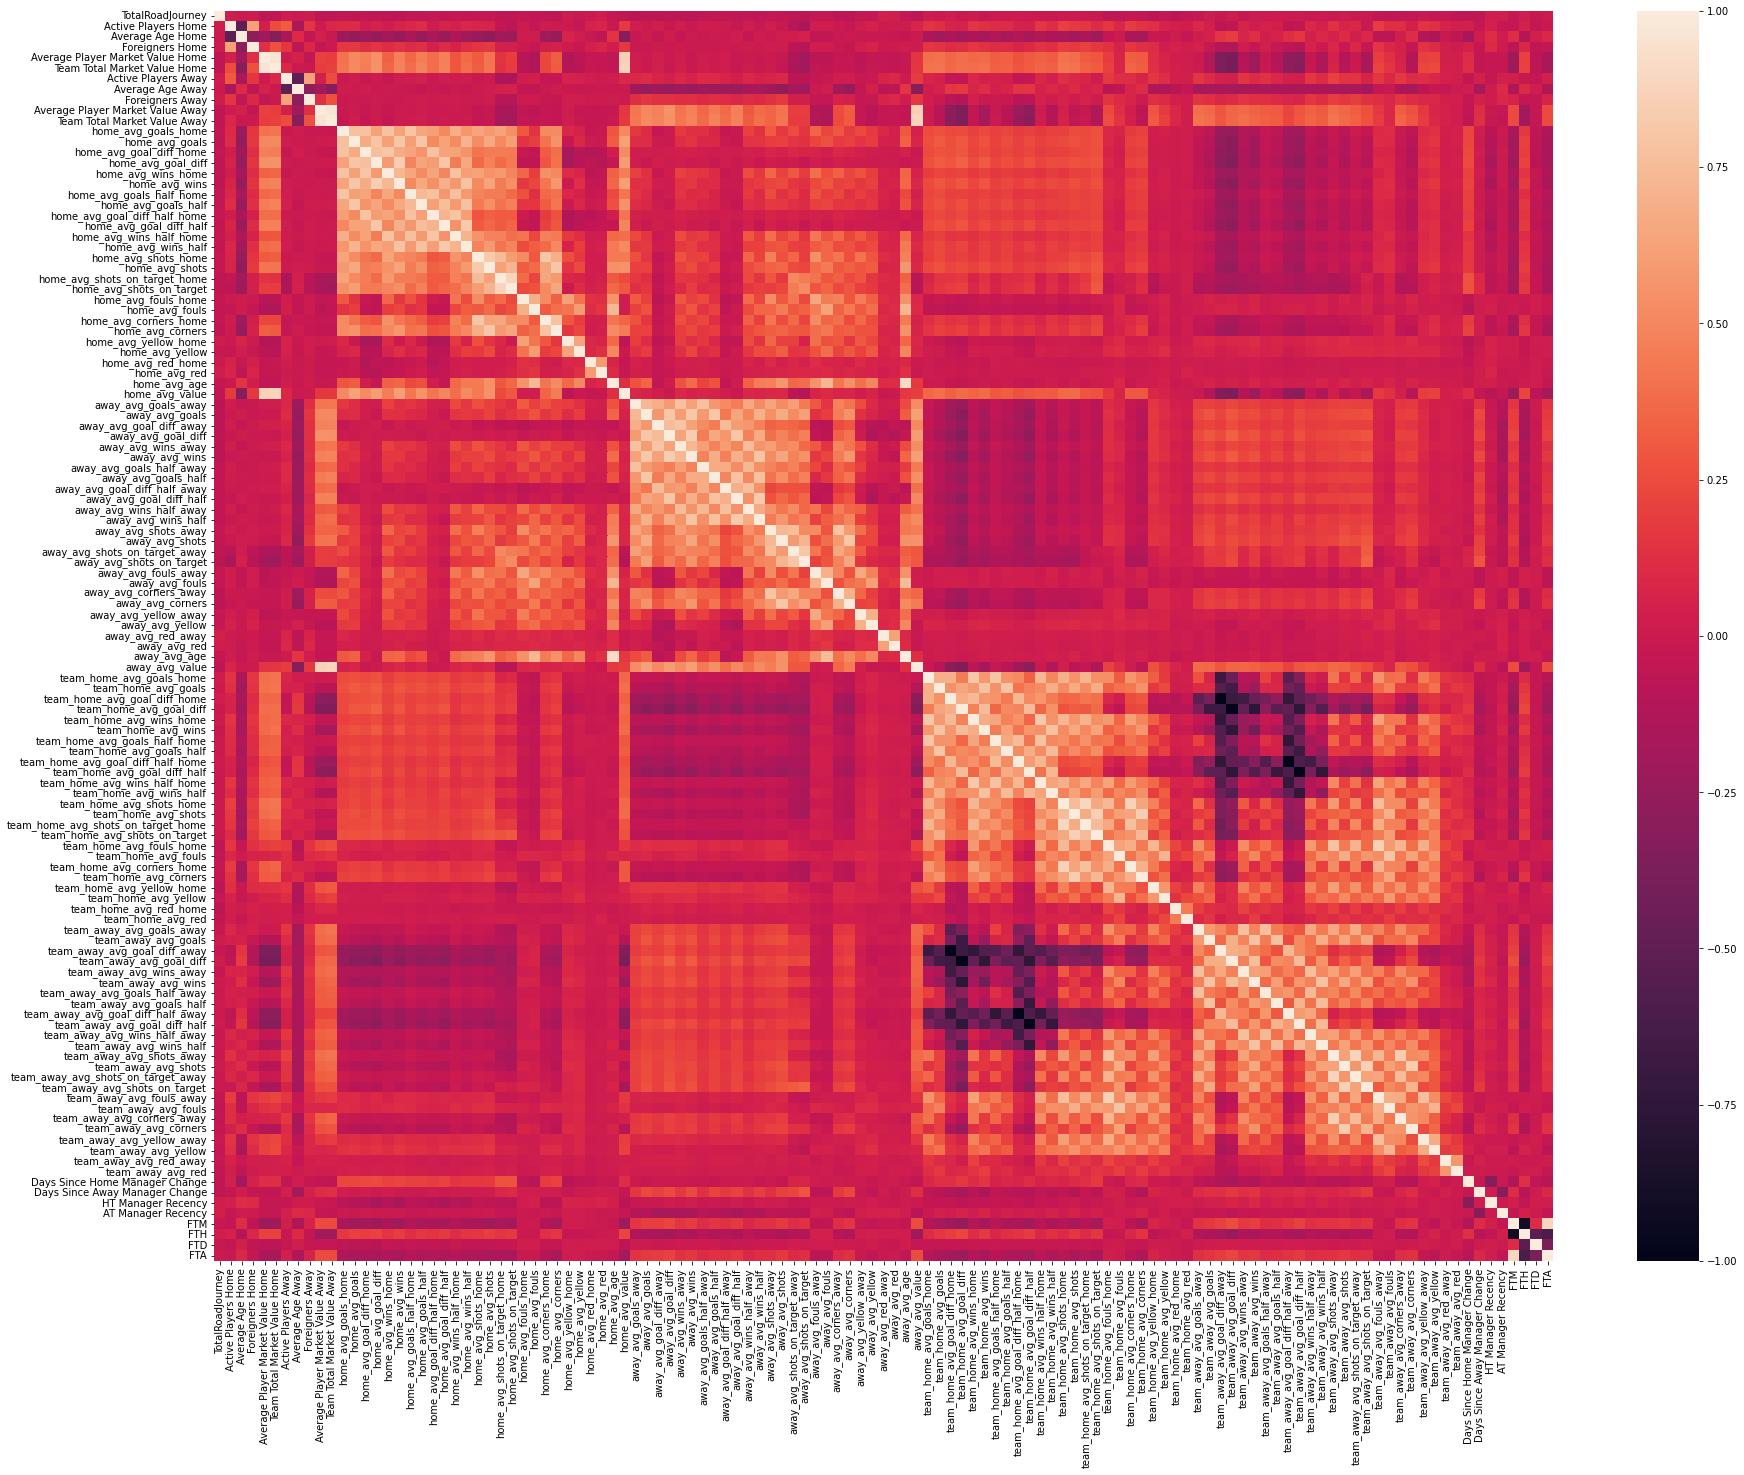

In [130]:
#plot correlogram with all variables
plt.figure(figsize=(30,23))
sns.heatmap(train.corr());

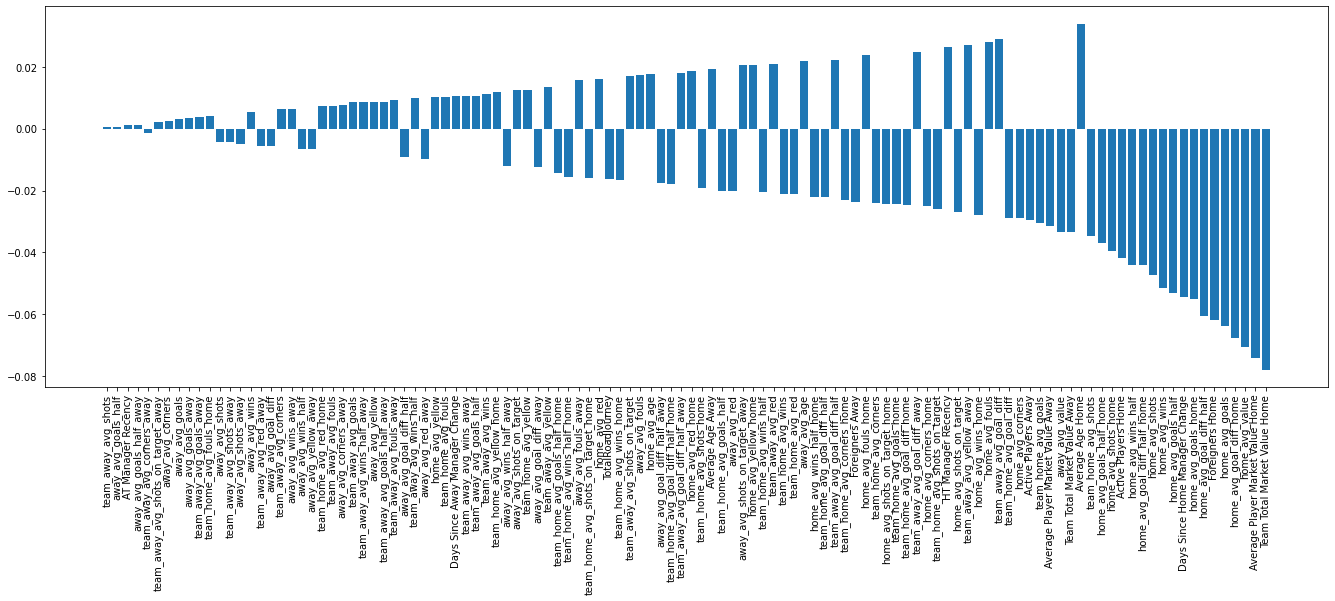

In [131]:
#create a list with all correlations between all variables and FTD
columnss = train.columns.values.tolist()[2:-4]
columnss.append('FTD')
corrs=train[columnss].corr()['FTD'][:]
corrs=pd.DataFrame(corrs)
corrs["absolute"]=abs(corrs['FTD'])
corrs=corrs.iloc[:-1,:]
corrs=corrs.sort_values(by='absolute') #sort values by correlation size
corrs['Variables'] = corrs.index
#plot correlations between all variables and FTD
plt.figure(figsize=(23,7))
plt.xticks(rotation=90);
plt.bar(corrs.iloc[:-1,2],corrs.iloc[:-1,0])#exclude  FTM
plt.show()

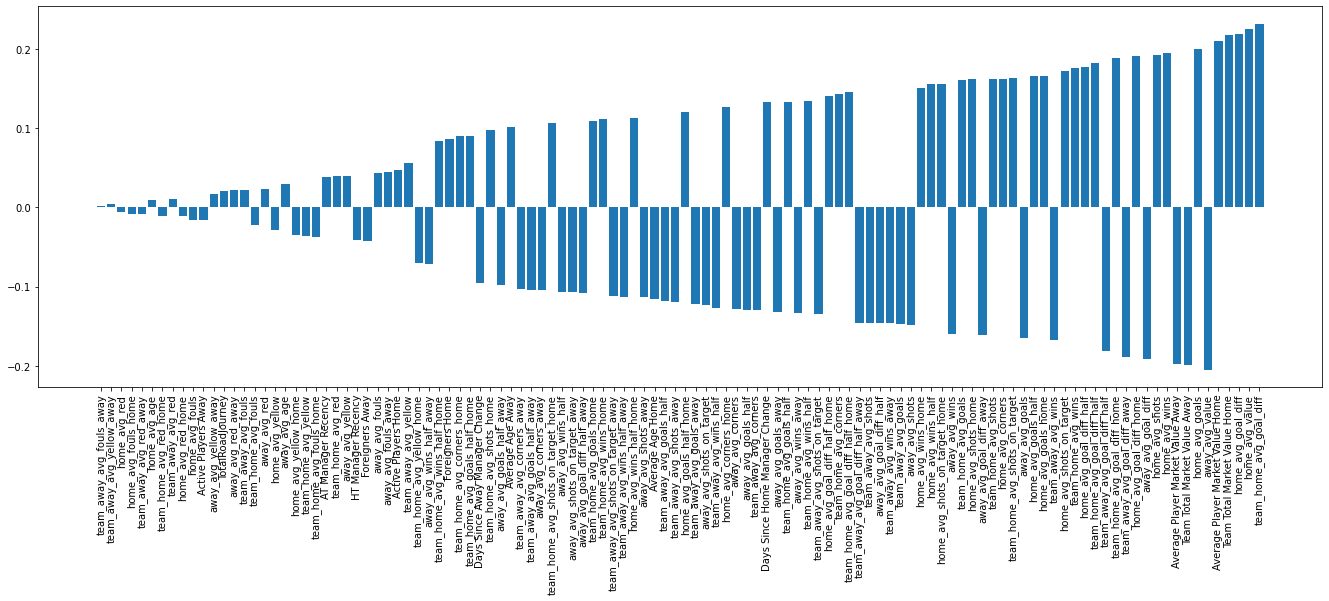

In [132]:
#create a list with all correlations between all variables and FTH
columnss = train.columns.values.tolist()[2:-4]
columnss.append('FTH')
corrs=train[columnss].corr()['FTH'][:]
corrs=pd.DataFrame(corrs)
corrs["absolute"]=abs(corrs['FTH'])
corrs=corrs.iloc[:-1,:]
corrs=corrs.sort_values(by='absolute') #sort values by correlation size
corrs['Variables'] = corrs.index
#plot correlations between all variables and FTD
plt.figure(figsize=(23,7))
plt.xticks(rotation=90);
plt.bar(corrs.iloc[:-1,2],corrs.iloc[:-1,0])#exclude  FTM
plt.show()

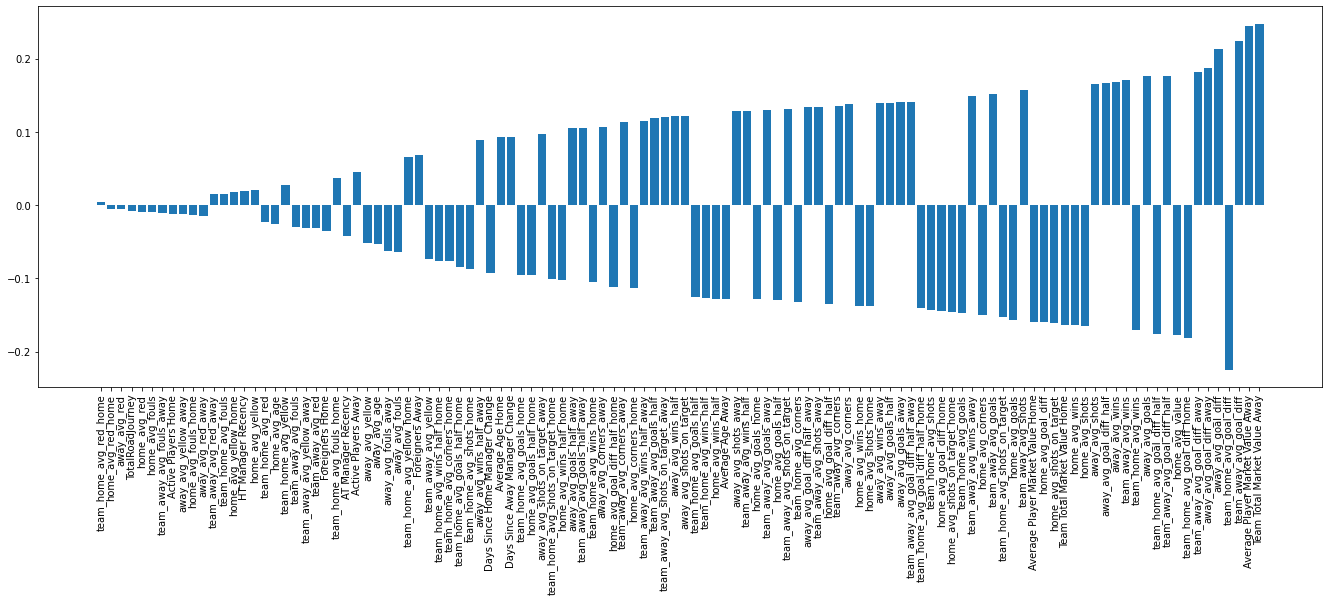

In [133]:
#create a list with all correlations between all variables and FTA
columnss = train.columns.values.tolist()[2:-4]
columnss.append('FTA')
corrs=train[columnss].corr()['FTA'][:]
corrs=pd.DataFrame(corrs)
corrs["absolute"]=abs(corrs['FTA'])
corrs=corrs.iloc[:-1,:]
corrs=corrs.sort_values(by='absolute') #sort values by correlation size
corrs['Variables'] = corrs.index
#plot correlations between all variables and FTD
plt.figure(figsize=(23,7))
plt.xticks(rotation=90);
plt.bar(corrs.iloc[:-1,2],corrs.iloc[:-1,0])#exclude  FTM
plt.show()

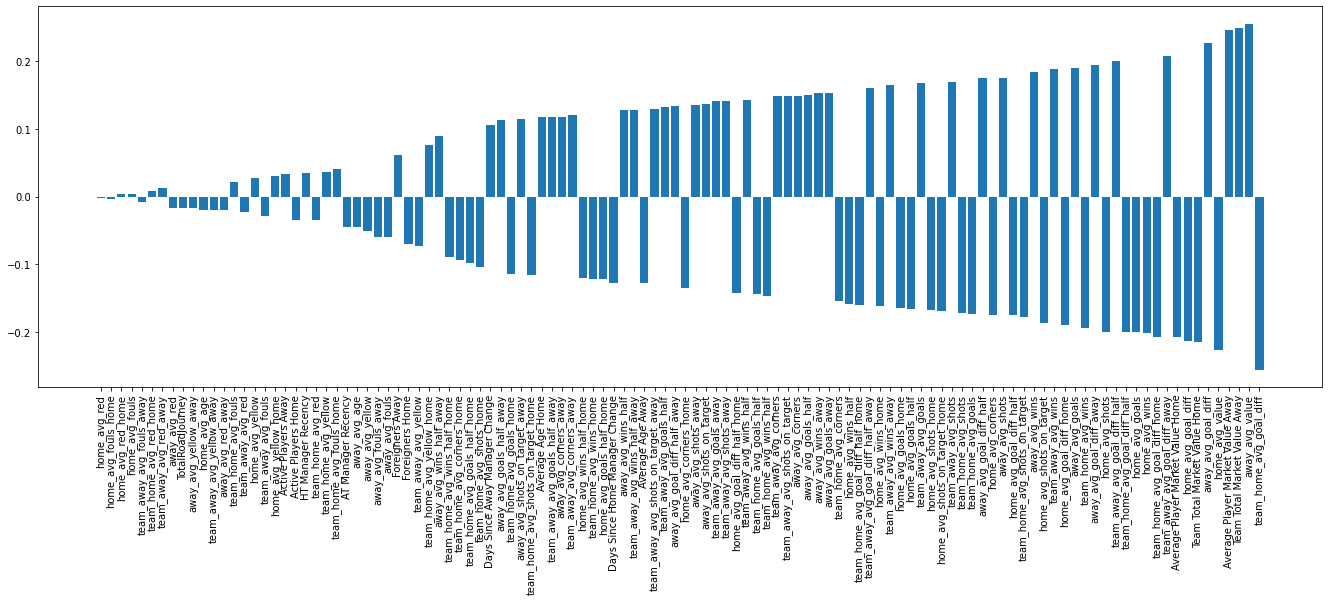

In [134]:
#create a list with all correlations between all variables and FTM
columnss = train.columns.values.tolist()[2:-4]
columnss.append('FTM')
corrs=train[columnss].corr()['FTM'][:]
corrs=pd.DataFrame(corrs)
corrs["absolute"]=abs(corrs['FTM'])
corrs=corrs.iloc[:-1,:]
corrs=corrs.sort_values(by='absolute') #sort values by correlation size
corrs['Variables'] = corrs.index
#plot correlations between all variables and FTM
plt.figure(figsize=(23,7))
plt.xticks(rotation=90);
plt.bar(corrs.iloc[:-1,2],corrs.iloc[:-1,0])#exclude  FTM
plt.show()

In [135]:
train = train.drop(columns=['FTH', 'FTA', 'FTD'])

In [136]:
#creating a data set with only correlations above 0.08
#threshold 0.08 to filter out correlation values below 0.08
features = corrs.loc[corrs["absolute"] > 0.08]
columns = list(features.iloc[:, 2])
Xbig = train[columns]
Xbig

,away_avg_wins_half_away,team_home_avg_wins_half_home,team_home_avg_corners_home,team_home_avg_goals_half_home,team_home_avg_shots_home,Days Since Away Manager Change,away_avg_goals_half_away,team_home_avg_goals_home,away_avg_shots_on_target_away,team_home_avg_shots_on_target_home,Average Age Home,team_away_avg_goals_half_away,away_avg_corners_away,team_away_avg_corners_away,home_avg_wins_half_home,team_home_avg_wins_home,home_avg_goals_half_home,Days Since Home Manager Change,away_avg_wins_half,team_away_avg_wins_half_away,Average Age Away,team_away_avg_shots_on_target_away,team_away_avg_goals_half,away_avg_goal_diff_half_away,home_avg_corners_home,away_avg_shots_away,away_avg_shots_on_target,team_away_avg_goals_away,team_away_avg_shots_away,home_avg_goal_diff_half_home,team_away_avg_wins_half,team_home_avg_goals_half,team_home_avg_wins_half,team_away_avg_corners,team_away_avg_shots_on_target,away_avg_corners,away_avg_goals_half,away_avg_wins_away,away_avg_goals_away,team_home_avg_corners,...,team_away_avg_goal_diff_half_away,home_avg_wins_home,team_away_avg_wins_away,home_avg_goals_home,home_avg_goals_half,team_away_avg_goals,home_avg_shots_home,home_avg_shots_on_target_home,team_away_avg_shots,team_home_avg_shots,team_home_avg_goals,away_avg_goal_diff_half,home_avg_corners,away_avg_shots,home_avg_goal_diff_half,team_home_avg_shots_on_target,away_avg_wins,home_avg_shots_on_target,team_away_avg_wins,home_avg_goal_diff_home,away_avg_goals,team_home_avg_wins,away_avg_goal_diff_away,home_avg_shots,team_away_avg_goal_diff_half,team_home_avg_goal_diff_half,home_avg_goals,home_avg_wins,team_home_avg_goal_diff_home,team_away_avg_goal_diff_away,Average Player Market Value Home,home_avg_goal_diff,Team Total Market Value Home,away_avg_goal_diff,home_avg_value,Average Player Market Value Away,Team Total Market Value Away,away_avg_value,team_home_avg_goal_diff,team_away_avg_goal_diff
0,0.000000,0.000,0.000000,0.000000,0.0,668.0,0.000000,0.000000,0.000000,0.000000,21.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4337.0,0.000000,0.000,24.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5940000.0,0.000000,225770000.0,0.000000,0.000000e+00,1920000.0,57650000.0,0.000000e+00,0.000000,0.000000
1,0.000000,0.000,0.000000,0.000000,0.0,793.0,0.000000,0.000000,0.000000,0.000000,25.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,296.0,0.000000,0.000,26.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2540000.0,0.000000,76230000.0,0.000000,0.000000e+00,1540000.0,44730000.0,0.000000e+00,0.000000,0.000000
2,0.000000,0.000,0.000000,0.000000,0.0,55.0,0.000000,0.000000,0.000000,0.000000,24.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2346.0,0.000000,0.000,26.4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5220000.0,0.000000,146300000.0,0.000000,0.000000e+00,3000000.0,78080000.0,0

In [137]:
columns

['away_avg_wins_half_away',
 'team_home_avg_wins_half_home',
 'team_home_avg_corners_home',
 'team_home_avg_goals_half_home',
 'team_home_avg_shots_home',
 'Days Since Away Manager Change',
 'away_avg_goals_half_away',
 'team_home_avg_goals_home',
 'away_avg_shots_on_target_away',
 'team_home_avg_shots_on_target_home',
 'Average Age Home',
 'team_away_avg_goals_half_away',
 'away_avg_corners_away',
 'team_away_avg_corners_away',
 'home_avg_wins_half_home',
 'team_home_avg_wins_home',
 'home_avg_goals_half_home',
 'Days Since Home Manager Change',
 'away_avg_wins_half',
 'team_away_avg_wins_half_away',
 'Average Age Away',
 'team_away_avg_shots_on_target_away',
 'team_away_avg_goals_half',
 'away_avg_goal_diff_half_away',
 'home_avg_corners_home',
 'away_avg_shots_away',
 'away_avg_shots_on_target',
 'team_away_avg_goals_away',
 'team_away_avg_shots_away',
 'home_avg_goal_diff_half_home',
 'team_away_avg_wins_half',
 'team_home_avg_goals_half',
 'team_home_avg_wins_half',
 'team_away_av

In [138]:
#creating a data set with only correlations above 0.18
#threshold 0.18 to filter out correlation values below 0.18
features = corrs.loc[corrs["absolute"] > 0.18]
columns = list(features.iloc[:, 2])
Xsmall = train[columns]
Xsmall

,away_avg_wins,home_avg_shots_on_target,team_away_avg_wins,home_avg_goal_diff_home,away_avg_goals,team_home_avg_wins,away_avg_goal_diff_away,home_avg_shots,team_away_avg_goal_diff_half,team_home_avg_goal_diff_half,home_avg_goals,home_avg_wins,team_home_avg_goal_diff_home,team_away_avg_goal_diff_away,Average Player Market Value Home,home_avg_goal_diff,Team Total Market Value Home,away_avg_goal_diff,home_avg_value,Average Player Market Value Away,Team Total Market Value Away,away_avg_value,team_home_avg_goal_diff,team_away_avg_goal_diff
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5940000.0,0.000000,225770000.0,0.000000,0.000000e+00,1920000.0,57650000.0,0.000000e+00,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2540000.0,0.000000,76230000.0,0.000000,0.000000e+00,1540000.0,44730000.0,0.000000e+00,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5220000.0,0.000000,146300000.0,0.000000,0.000000e+00,3000000.0,78080000.0,0.000000e+00,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1290000.0,0.000000,34760000.0,0.000000,0.000000e+00,2060000.0,65790000.0,0.000000e+00,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2210000.0,0.000000,66290000.0,0.000000,0.000000e+00,5470000.0,191340000.0,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5084,0.428571,4.285714,0.000000,-0.285714,1.214286,0.000000,-0.142857,14.357143,0.000000,0.000000,0.928571,0.428571,0.000000,0.000000,9310000.0,-0.500000,232830000.0,-0.142857,1.533117e+07,5810000.0,179960000.0,9.497402e+06,0.000000,0.000000
5085,0.464286,5.142857,0.218750,0.000000,1.357143,0.781250,-0.714286,13.642857,-0.437500,0.437500,1.714286,0.535714,1.000000,-1.000000,28280000.0,0.000000,820130000.0,-0.071429,3.662987e+07,8630000.0,224510000.0,9.798701e+06,1.062500,-1.062500
5086,0.285714,3.846154,0.350000,0.000000,0.571429,0.650000,-2.000000,10.384615,-0.400000,0.400000,1.000000,0.576923,1.000000,-1.000000,26140000.0,-0.307692,627300000.0,-1.428571,2.302098e+07,5990000.0,167810000.0,7.881818e+06,0.900000,-0.900000
5087,0.500000,3.571429,0.687500,0.285714,1.571429,0.312500,-0.285714,11.214286,0.625000,-0.625000,1.357143,0.392857,-0.750000,0.750000,14870000.0,-0.285714,371790000.0,-0.214286,1.656688e+07,17620000.0,493290000.0,2.055195e+07,-1.000000,1.000000


##Data Scaling and splitting 

In [235]:
#scaling data 
scaler = MinMaxScaler()
X=train.iloc[:,2:-1]
X = scaler.fit_transform(X)
Xbig = scaler.fit_transform(Xbig)
Xsmall = scaler.fit_transform(Xsmall)

In [236]:
#splitting into training and testing
y=train.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  
Xsmall_train, Xsmall_test, ysmall_train, ysmall_test = train_test_split(Xsmall, y, test_size=0.2)
Xbig_train, Xbig_test, ybig_train, ybig_test = train_test_split(Xbig, y, test_size=0.2)

In [237]:
print(train)

     FTR HTR  TotalRoadJourney  ...  HT Manager Recency  AT Manager Recency  FTM
0      H   H        179.520664  ...                 0.0                 0.0  0.0
1      H   H         81.839376  ...                 0.0                 0.0  0.0
2      A   D         56.668483  ...                 0.0                 1.0  2.0
3      H   D        281.120755  ...                 0.0                 0.0  0.0
4      H   D        381.386538  ...                 0.0                 0.0  0.0
...   ..  ..               ...  ...                 ...                 ...  ...
5084   D   H        302.111504  ...                 0.0                 0.0  1.0
5085   H   D        306.763453  ...                 1.0                 0.0  0.0
5086   H   H        168.282705  ...                 1.0                 1.0  0.0
5087   H   D         62.556061  ...                 1.0                 0.0  0.0
5088   H   A        313.219294  ...                 1.0                 0.0  0.0

[5055 rows x 124 columns]


# 4. Methodology

In this section of the report, we summarized our approach including which models we trained, how we evaluated them, and how we optimized them. A step by step description follows in the model training and validation section, and the equivalent code.

# 5. Model Training & Validation

##Logistic Regression Training, Cross Validation and Hyperparameter Optimisations (C)

In [143]:
#Define accuracy plotting function 
def plot_accuracy(C, accuracy_dict,title):
    for label, accuracy in accuracy_dict.items():
        plt.plot(C, accuracy, label=label)

    # add labels for x and y axis
    plt.xlabel('C')
    plt.ylabel('classification accuracy')
    plt.legend()
    plt.title(title)
    plt.show()

In [144]:
#A function to find accuracies for different hyperparameter
#C being the inverse of regularization strength
def logistic_regression_accuracy(X_train, X_test, y_train, y_test):
    C=[0.001,0.005,0.01,0.05,0.1, 0.2]
    accuracy_train, accuracy_test= [], []
    for c in C:
        lr = LogisticRegression(solver='liblinear', multi_class='ovr',C=c)
        lr.fit(X_train, y_train)
        #predict train
        y_lr_train = lr.predict(X_train)
        #predict test
        y_lr_test = lr.predict(X_test)
        #in-sample accuracy (train)
        accuracy_train.append(accuracy_score(y_train,y_lr_train)) 
        #out of sample accuracy (test)
        accuracy_test.append(accuracy_score(y_test,y_lr_test))
    # plot train and test accuracy
    return accuracy_train, accuracy_test

In [145]:
#accuracies for different hyper parametiers on the 3 data sets 
accuracy_train, accuracy_test = logistic_regression_accuracy(X_train, X_test, y_train, y_test)
accuracy_trainsmall, accuracy_testsmall = logistic_regression_accuracy(Xsmall_train, Xsmall_test, ysmall_train, ysmall_test)
accuracy_trainbig, accuracy_testbig = logistic_regression_accuracy(Xbig_train, Xbig_test, ybig_train, ybig_test)

In [146]:
#a function for cross validation for logistic regression
def cv_accuracy(X, y):
    kf = KFold(n_splits=5)  # 5-fold cross validation
    C=[0.001,0.005,0.01,0.05,0.1, 0.2]
    #create empty arrays 
    accuracy_validation = np.empty((5,len(C)))
    #for all folds splitting into training and validation set
    for k, (index_train, index_validation) in enumerate(kf.split(X)):  
        X_small_train, X_validation = X[index_train, :], X[index_validation, :]
        y_small_train, y_validation = y.iloc[index_train], y.iloc[index_validation]
        #loop for all hyperparameters
        for l, c in enumerate(C):
            # compute classification accuracy on validation set
            lr = LogisticRegression(solver='liblinear', C =c,multi_class='ovr')
            #train model
            lr.fit(X_small_train, y_small_train)
            predict_validation = lr.predict(X_validation)  # validation 
            accuracy_validation[k,l] = accuracy_score(y_validation, predict_validation)
    # compute mean validation accuracy for 5 folds
    # solution
    accuracy_validation = np.mean(accuracy_validation, axis=0)
    return accuracy_validation

In [147]:
#accuracies for different hyperparametiers on the 3 data sets 
accuracy_validation = cv_accuracy(X, y)
accuracy_validationsmall = cv_accuracy(Xsmall, y)
accuracy_validationbig = cv_accuracy(Xbig, y)

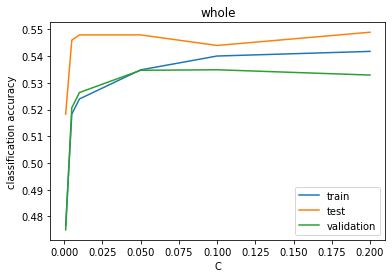

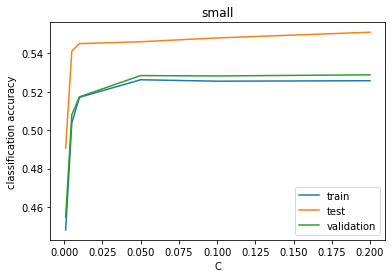

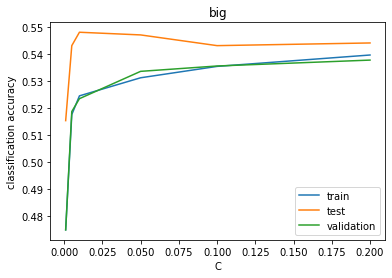

In [148]:
#Plotting accuracies of the models trained on the 3 data sets for different hyperarameters 
C=[0.001,0.005,0.01,0.05,0.1, 0.2]
plot_accuracy(C, {'train': accuracy_train, 'test': accuracy_test, 'validation': accuracy_validation},'whole')
plot_accuracy(C, {'train': accuracy_trainsmall, 'test': accuracy_testsmall, 'validation': accuracy_validationsmall},'small')
plot_accuracy(C, {'train': accuracy_trainbig, 'test': accuracy_testbig, 'validation': accuracy_validationbig},'big')

In [149]:
#A function to find accuracies for a specific hyperparameter
def logistic_regression_accuracy_C(X_train, X_test, y_train, y_test,c_train,c_test):
    accuracy_train, accuracy_test= [], []
    lrtrain = LogisticRegression(solver='liblinear', C=c_train) #C as a hyperparameter 
    lrtrain.fit(X_train, y_train)
    #predict train
    y_lr_train = lrtrain.predict(X_train)
    #predict test
    lrtest = LogisticRegression(solver='liblinear', C=c_test) #C as a hyperparameter 
    lrtest.fit(X_train, y_train)
    y_lr_test = lrtest.predict(X_test)
    #in-sample accuracy (train)
    accuracy_train.append(accuracy_score(y_train,y_lr_train)) 
    #out of sample accuracy (test)
    accuracy_test.append(accuracy_score(y_test,y_lr_test))
    return accuracy_train, accuracy_test

In [150]:
#Saving optimal hyperparameters
Ctrain=C[np.argmax(accuracy_train)]
Ctrainsmall=C[np.argmax(accuracy_trainsmall)]
Ctrainbig=C[np.argmax(accuracy_trainbig)]

Ctest=C[np.argmax(accuracy_test)]
Ctestsmall=C[np.argmax(accuracy_testsmall)]
Ctestbig=C[np.argmax(accuracy_testbig)]

In [151]:
#printed optimal c's
print(Ctrain,Ctrainsmall,Ctrainbig,Ctest,Ctestsmall,Ctestbig)

0.2 0.05 0.2 0.2 0.2 0.01


In [152]:
#accuracies for optimal hyperparametiers on the 3 data sets
b_accuracy_train, b_accuracy_test = logistic_regression_accuracy_C(X_train, X_test, y_train, y_test,Ctrain, Ctest)
b_accuracy_trainsmall, b_accuracy_testsmall = logistic_regression_accuracy_C(Xsmall_train, Xsmall_test, ysmall_train, ysmall_test,Ctrainsmall,Ctestsmall)
b_accuracy_trainbig, b_accuracy_testbig = logistic_regression_accuracy_C(Xbig_train, Xbig_test, ybig_train, ybig_test,Ctrainbig,Ctestbig)

In [153]:
#cross validation with the optimal hyperparameters
def cv_accuracy_C(X, y,c):
    kf = KFold(n_splits=5)  # 5-fold cross validation
    #create empty arrays 
    accuracy_validation = np.empty((5))
    #for all folds splitting into training and validation set
    for k, (index_train, index_validation) in enumerate(kf.split(X)):  
        X_small_train, X_validation = X[index_train, :], X[index_validation, :]
        y_small_train, y_validation = y.iloc[index_train], y.iloc[index_validation]
        # compute classification accuracy on validation set
        lr = LogisticRegression(solver='liblinear', C =c)
        #train model
        lr.fit(X_small_train, y_small_train)
        predict_validation = lr.predict(X_validation)  # validation   
        accuracy_validation[k] = accuracy_score(y_validation, predict_validation)
    #compute mean validation accuracy for 5 folds
    #solution
    accuracy_validation = np.mean(accuracy_validation, axis=0)
    return accuracy_validation

In [154]:
Cmax=C[np.argmax(accuracy_validation)]
Cmax
Csmall=C[np.argmax(accuracy_validationsmall)]
Csmall
Cbig=C[np.argmax(accuracy_validationbig)]
Cbig
#printing cross validation optimal C values
print(Cmax,Csmall,Cbig)

0.1 0.2 0.2


In [155]:
b_accuracy_validation = cv_accuracy_C(X, y,Cmax)
b_accuracy_validationsmall = cv_accuracy_C(Xsmall, y,Csmall)
b_accuracy_validationbig = cv_accuracy_C(Xbig, y,Cbig)

In [156]:
#Accuracy table 
results= {'model' : ['Logistic Regression full','Logistic Regresion small th', 'Logistic Regression big th' ],
             'train_accuracy': [b_accuracy_train[0],b_accuracy_trainsmall[0],b_accuracy_trainbig[0]],
             'test_accuracy': [b_accuracy_test[0],b_accuracy_testbig[0],b_accuracy_testsmall[0]],
             'validation_accuracy': [b_accuracy_validation,b_accuracy_validationsmall,b_accuracy_validationbig]}
accuracy=pd.DataFrame.from_dict(results)
accuracy

,model,train_accuracy,test_accuracy,validation_accuracy
0,Logistic Regression full,0.541790,0.548961,0.534916
1,Logistic Regresion small th,0.526212,0.547972,0.528783
2,Logistic Regression big th,0.539565,0.550940,0.537685


##Naive Bayes,Cross Validation

In [157]:
#training a multinomial naive bayes on the 3 data sets 
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
y_pred = nb.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred)

In [158]:
nb = MultinomialNB()
nb.fit(Xbig_train, ybig_train)
y_pred = nb.predict(Xbig_test)
accuracy_testbig = accuracy_score(ybig_test, y_pred)
y_pred = nb.predict(Xbig_train)
accuracy_trainbig = accuracy_score(ybig_train, y_pred)

In [159]:
nb = MultinomialNB()
nb.fit(Xsmall_train, ysmall_train)
y_pred = nb.predict(Xsmall_test)
accuracy_testsmall = accuracy_score(ysmall_test, y_pred)
y_pred = nb.predict(Xsmall_train)
accuracy_trainsmall = accuracy_score(ysmall_train, y_pred)

In [160]:
#a function for cross validation for naive bayes
def nb_cross_validation(X, y):
    kf = KFold(n_splits=5)  # 5-fold cross validation
        #create empty arrays 
    accuracy_validation = np.empty((5))
        #for all folds splitting into training and validation set
    for k, (index_train, index_validation) in enumerate(kf.split(X)):  
        X_small_train, X_validation = X[index_train, :], X[index_validation, :]
        y_small_train, y_validation = y.iloc[index_train], y.iloc[index_validation]
        nb = MultinomialNB()
        nb.fit(X_small_train, y_small_train)
        y_pred = nb.predict(X_validation)
        accuracy_validation[k] = accuracy_score(y_validation, y_pred)
        # compute mean validation accuracy for 5 folds
        # solution
    accuracy_validation = np.mean(accuracy_validation, axis=0)
    return accuracy_validation

In [161]:
#accuracies on the 3 data sets 
accuracy_validation = nb_cross_validation(X, y)
accuracy_validationsmall = nb_cross_validation(Xsmall, y)
accuracy_validationbig = nb_cross_validation(Xbig, y)

In [162]:
#add values to the accuracy table 
accuracy = accuracy.append({'model': 'NB full','train_accuracy':accuracy_train,'test_accuracy':accuracy_test,'validation_accuracy': accuracy_validation}, ignore_index=True)
accuracy = accuracy.append({'model': 'NB small th','train_accuracy':accuracy_trainbig,'test_accuracy':accuracy_testbig,'validation_accuracy': accuracy_validationbig}, ignore_index=True)
accuracy = accuracy.append({'model': 'NB big th','train_accuracy':accuracy_trainsmall,'test_accuracy':accuracy_testsmall,'validation_accuracy': accuracy_validationsmall}, ignore_index=True)
accuracy

,model,train_accuracy,test_accuracy,validation_accuracy
0,Logistic Regression full,0.541790,0.548961,0.534916
1,Logistic Regresion small th,0.526212,0.547972,0.528783
2,Logistic Regression big th,0.539565,0.550940,0.537685
3,NB full,0.515579,0.546983,0.518497
4,NB small th,0.513106,0.542038,0.516518
5,NB big th,0.513106,0.545994,0.517705


##KNN Training, Cross Validation

In [163]:
#training a KNN on the 3 data sets 
knn = KNeighborsClassifier(n_neighbors=7) #an arbitrary value was set 
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred)
y_pred = knn.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred)

In [164]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(Xsmall_train, ysmall_train)
y_pred = knn.predict(Xsmall_test)
accuracy_testsmall = accuracy_score(ysmall_test, y_pred)
y_pred = knn.predict(Xsmall_train)
accuracy_trainsmall = accuracy_score(ysmall_train, y_pred)

In [165]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(Xbig_train, ybig_train)
y_pred = knn.predict(Xbig_test)
accuracy_testbig = accuracy_score(ybig_test, y_pred)
y_pred = knn.predict(Xbig_train)
accuracy_trainbig = accuracy_score(ybig_train, y_pred)

In [166]:
#a function for cross validation for KNN
def cv_accuracy_knn(X, y):
    kf = KFold(n_splits=5)  # 5-fold cross validation
    #create empty arrays 
    accuracy_validation = np.empty((5))
    #for all folds splitting into training and validation set
    for k, (index_train, index_validation) in enumerate(kf.split(X)):  
        X_small_train, X_validation = X[index_train, :], X[index_validation, :]
        y_small_train, y_validation = y.iloc[index_train], y.iloc[index_validation]  
        # compute classification accuracy on validation set
        lknn = KNeighborsClassifier(n_neighbors=7)
        #train model
        knn.fit(X_small_train, y_small_train)
        predict_validation = knn.predict(X_validation)  # validation 
        accuracy_validation[k] = accuracy_score(y_validation, predict_validation)
    # compute mean validation accuracy for 5 folds
    # solution
    accuracy_validation = np.mean(accuracy_validation, axis=0)
    return accuracy_validation

In [167]:
#accuracies on the 3 data sets 
accuracy_validation = cv_accuracy_knn(X, y)
accuracy_validationsmall = cv_accuracy_knn(Xsmall, y)
accuracy_validationbig = cv_accuracy_knn(Xbig, y)

In [168]:
#add values to the accuracy table 
accuracy = accuracy.append({'model': 'KNN full th','train_accuracy':accuracy_train,'test_accuracy':accuracy_test,'validation_accuracy': accuracy_validation}, ignore_index=True)
accuracy = accuracy.append({'model': 'KNN small th','train_accuracy':accuracy_trainbig,'test_accuracy':accuracy_testbig,'validation_accuracy': accuracy_validationbig}, ignore_index=True)
accuracy = accuracy.append({'model': 'KNN big th','train_accuracy':accuracy_trainsmall,'test_accuracy':accuracy_testsmall,'validation_accuracy': accuracy_validationsmall}, ignore_index=True)
accuracy

,model,train_accuracy,test_accuracy,validation_accuracy
0,Logistic Regression full,0.541790,0.548961,0.534916
1,Logistic Regresion small th,0.526212,0.547972,0.528783
2,Logistic Regression big th,0.539565,0.550940,0.537685
3,NB full,0.515579,0.546983,0.518497
4,NB small th,0.513106,0.542038,0.516518
5,NB big th,0.513106,0.545994,0.517705
6,KNN full th,0.603858,0.462908,0.454797
7,KNN small th,0.595697,0.490603,0.469832
8,KNN big th,0.603116,0.508408,0.481306


##SVM -rbf,ovo,ovr-  Cross Validation and Hyperparameter Optimisations (gammas)


In [169]:
#Define accuracy plotting function 
def plot_accuracy(gammasss, accuracy_dict,title): #Defining plot accuracy function 
    for label, accuracy in accuracy_dict.items():
        plt.plot(gammasss, accuracy, label=label)

    # add labels for x and y axis
    plt.xlabel('gamma')
    plt.ylabel('classification accuracy')
    plt.legend()
    plt.title(title)
    plt.show()

In [170]:
#A function to find cross validation accuracies of the SVM rbf for different gammas 
def plot_accuracy_svm_rbf(X_train, X_test, y_train, y_test, X, y):
    gammas = np.power(2, np.linspace(-20, -4, 15))
    kf = KFold(n_splits=5, random_state=42, shuffle=True)  # 5-fold cross validation

    # validation accuracy
    accuracy_validation = np.empty((5, len(gammas)))
    for k, (index_train, index_validation) in enumerate(kf.split(X)):
        X_small_train, X_validation = X[index_train, :], X[index_validation, :]
        y_small_train, y_validation = y.take(index_train), y.take(index_validation)
        for l, gamma in enumerate(gammas):
            svm = SVC(kernel='rbf', gamma=gamma)
            svm.fit(X_small_train, y_small_train)
            predict_validation = svm.predict(X_validation)  # validation
            accuracy_validation[k, l] = accuracy_score(y_validation, predict_validation)    
    accuracy_validation = np.mean(accuracy_validation, axis=0)

    # train and test accuracy
    accuracy_train, accuracy_test = [], []
    for gamma in gammas:
        svm = SVC(kernel='rbf', gamma=gamma)
        svm.fit(X_train, y_train)
        predict_train = svm.predict(X_train)
        accuracy_train.append(accuracy_score(y_train, predict_train))
        predict_test = svm.predict(X_test)
        accuracy_test.append(accuracy_score(y_test, predict_test))
    return gammas, accuracy_train, accuracy_test, accuracy_validation

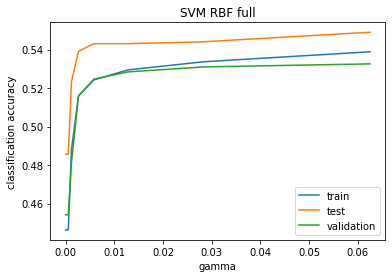

In [171]:
#plot the mean validation accuracy, train and test accuracy on the 3 data sets
gammas, train_accuracy, test_accuracy, validation_accuracy = plot_accuracy_svm_rbf(X_train, X_test, y_train, y_test, X, y)
plot_accuracy(gammas, {'train': train_accuracy, 
                          'test': test_accuracy,
                          'validation': validation_accuracy}, 'SVM RBF full')

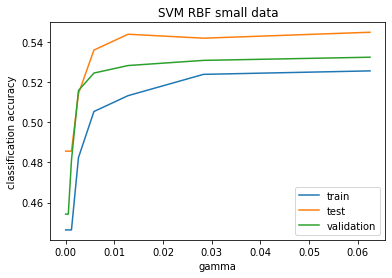

In [172]:
gammassmall, train_accuracysmall, test_accuracysmall, validation_accuracysmall = plot_accuracy_svm_rbf(Xsmall_train, Xsmall_test, ysmall_train, ysmall_test, X, y)
plot_accuracy(gammassmall, {'train': train_accuracysmall, 
                          'test': test_accuracysmall,
                          'validation': validation_accuracysmall}, 'SVM RBF small data')

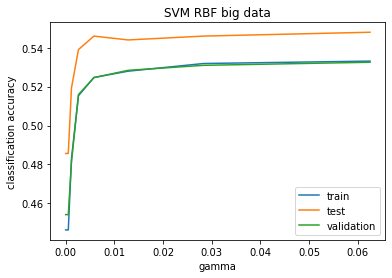

In [173]:
gammasbig, train_accuracybig, test_accuracybig, validation_accuracybig = plot_accuracy_svm_rbf(Xbig_train, Xbig_test, ybig_train, ybig_test, X, y)
plot_accuracy(gammasbig, {'train': train_accuracybig, 
                          'test': test_accuracybig,
                          'validation': validation_accuracybig}, 'SVM RBF big data')

In [174]:
#print optimal gammas
#full dataset
gtrain=gammas[np.argmax(train_accuracy)]
gtest=gammas[np.argmax(test_accuracy)]
gvalidation=gammas[np.argmax(validation_accuracy)]

#small dataset
gtrainsmall=gammas[np.argmax(train_accuracysmall)]
gtestsmall=gammas[np.argmax(test_accuracysmall)]
gvalidationsmall=gammas[np.argmax(validation_accuracysmall)]

#big dataset
gtrainbig=gammas[np.argmax(train_accuracybig)]
gtestbig=gammas[np.argmax(test_accuracybig)]
gvalidationbig=gammas[np.argmax(validation_accuracybig)]

print(gtrain,gtest,gvalidation,gtrainsmall,gtestsmall,gvalidationsmall,gtrainbig,gtestbig,gvalidationbig)

0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625


In [175]:
#accuracies on the 3 data sets 
acc_validation_small = validation_accuracysmall[np.argmax(validation_accuracysmall)]
acc_validation = validation_accuracy[np.argmax(validation_accuracy)]
acc_validation_big = validation_accuracybig[np.argmax(validation_accuracybig)]

acc_train =  train_accuracy[np.argmax(train_accuracy)]
acc_trainsmall = train_accuracysmall[np.argmax(train_accuracysmall)]
acc_trainbig = train_accuracybig[np.argmax(train_accuracybig)]

acc_test  = test_accuracy[np.argmax(test_accuracy)]
acc_testsmall = test_accuracysmall[np.argmax(test_accuracysmall)]
acc_testbig = test_accuracybig[np.argmax(test_accuracybig)]

In [176]:
#add values to the accuracy table 
accuracy = accuracy.append({'model': 'SVM rbf full ','train_accuracy':acc_train,'test_accuracy':acc_test,'validation_accuracy': acc_validation}, ignore_index=True)
accuracy = accuracy.append({'model': 'SVM rbf small th','train_accuracy':acc_trainbig,'test_accuracy':acc_testbig,'validation_accuracy': acc_validation_big}, ignore_index=True)
accuracy = accuracy.append({'model': 'SVM rbf big th','train_accuracy':acc_trainsmall,'test_accuracy':acc_testsmall,'validation_accuracy': acc_validation_small}, ignore_index=True)
accuracy

,model,train_accuracy,test_accuracy,validation_accuracy
0,Logistic Regression full,0.541790,0.548961,0.534916
1,Logistic Regresion small th,0.526212,0.547972,0.528783
2,Logistic Regression big th,0.539565,0.550940,0.537685
3,NB full,0.515579,0.546983,0.518497
4,NB small th,0.513106,0.542038,0.516518
5,NB big th,0.513106,0.545994,0.517705
6,KNN full th,0.603858,0.462908,0.454797
7,KNN small th,0.595697,0.490603,0.469832
8,KNN big th,0.603116,0.508408,0.481306
9,SVM rbf full,0.538823,0.548961,0.532542


In [177]:
#A function to find cross validation accuracies of the SVM ovo for different gammas 
def plot_accuracy_svm_ovo(X_train, X_test, y_train, y_test, X, y):
    gammas = np.power(2, np.linspace(-20, -4, 15))
    kf = KFold(n_splits=5, random_state=42, shuffle=True)  # 5-fold cross validation
    # validation accuracy
    accuracy_validation = np.empty((5, len(gammas)))
    for k, (index_train, index_validation) in enumerate(kf.split(X)):
        X_small_train, X_validation = X[index_train, :], X[index_validation, :]
        y_small_train, y_validation = y.take(index_train), y.take(index_validation)
        for l, gamma in enumerate(gammas):
            svm = SVC(kernel='linear', decision_function_shape='ovo', gamma=gamma)
            svm.fit(X_small_train, y_small_train)
            predict_validation = svm.predict(X_validation)  # validation
            accuracy_validation[k, l] = accuracy_score(y_validation, predict_validation)    
    accuracy_validation = np.mean(accuracy_validation, axis=0)
    # train and test accuracy
    accuracy_train, accuracy_test = [], []
    for gamma in gammas:
        svm = SVC(kernel='linear', decision_function_shape='ovo', gamma=gamma)
        svm.fit(X_train, y_train)
        predict_train = svm.predict(X_train)
        accuracy_train.append(accuracy_score(y_train, predict_train))
        predict_test = svm.predict(X_test)
        accuracy_test.append(accuracy_score(y_test, predict_test))
    return gammas, accuracy_train, accuracy_test, accuracy_validation

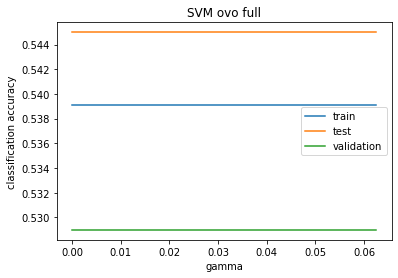

In [178]:
#plot the mean validation accuracy, train and test accuracy on the 3 data sets
gammas, train_accuracy, test_accuracy, validation_accuracy = plot_accuracy_svm_ovo(X_train, X_test, y_train, y_test, X, y)
plot_accuracy(gammas, {'train': train_accuracy, 
                          'test': test_accuracy,
                          'validation': validation_accuracy}, 'SVM ovo full')

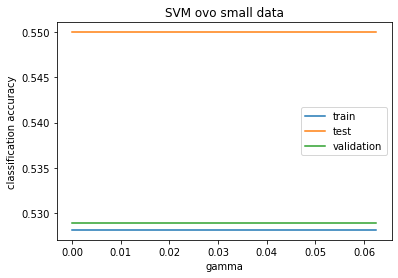

In [179]:
gammassmall, train_accuracysmall, test_accuracysmall, validation_accuracysmall = plot_accuracy_svm_ovo(Xsmall_train, Xsmall_test, ysmall_train, ysmall_test, X, y)
plot_accuracy(gammassmall, {'train': train_accuracysmall, 
                          'test': test_accuracysmall,
                          'validation': validation_accuracysmall}, 'SVM ovo small data')

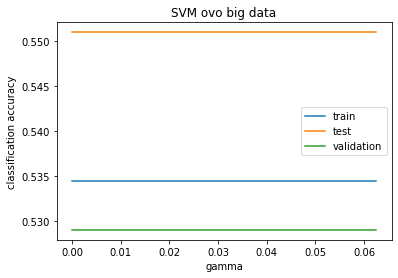

In [180]:
gammasbig, train_accuracybig, test_accuracybig, validation_accuracybig = plot_accuracy_svm_ovo(Xbig_train, Xbig_test, ybig_train, ybig_test, X, y)
plot_accuracy(gammasbig, {'train': train_accuracybig, 
                          'test': test_accuracybig,
                          'validation': validation_accuracybig}, 'SVM ovo big data')

In [181]:
#accuracies on the 3 data sets 
acc_validation_small = validation_accuracysmall[np.argmax(validation_accuracysmall)]
acc_validation = validation_accuracy[np.argmax(validation_accuracy)]
acc_validation_big = validation_accuracybig[np.argmax(validation_accuracybig)]

acc_train =  train_accuracy[np.argmax(train_accuracy)]
acc_trainsmall = train_accuracysmall[np.argmax(train_accuracysmall)]
acc_trainbig = train_accuracybig[np.argmax(train_accuracybig)]

acc_test  = test_accuracy[np.argmax(test_accuracy)]
acc_testsmall = test_accuracysmall[np.argmax(test_accuracysmall)]
acc_testbig = test_accuracybig[np.argmax(test_accuracybig)]

In [182]:
#add values to the accuracy table 
accuracy = accuracy.append({'model': 'SVM ovo full ','train_accuracy':acc_train,'test_accuracy':acc_test,'validation_accuracy': acc_validation}, ignore_index=True)
accuracy = accuracy.append({'model': 'SVM ovo small th','train_accuracy':acc_trainbig,'test_accuracy':acc_testbig,'validation_accuracy': acc_validation_big}, ignore_index=True)
accuracy = accuracy.append({'model': 'SVM ovo big th','train_accuracy':acc_trainsmall,'test_accuracy':acc_testsmall,'validation_accuracy': acc_validation_small}, ignore_index=True)
accuracy

,model,train_accuracy,test_accuracy,validation_accuracy
0,Logistic Regression full,0.541790,0.548961,0.534916
1,Logistic Regresion small th,0.526212,0.547972,0.528783
2,Logistic Regression big th,0.539565,0.550940,0.537685
3,NB full,0.515579,0.546983,0.518497
4,NB small th,0.513106,0.542038,0.516518
5,NB big th,0.513106,0.545994,0.517705
6,KNN full th,0.603858,0.462908,0.454797
7,KNN small th,0.595697,0.490603,0.469832
8,KNN big th,0.603116,0.508408,0.481306
9,SVM rbf full,0.538823,0.548961,0.532542


In [183]:
#A function to find cross validation accuracies of the SVM ovr for different gammas 
def plot_accuracy_svm_ovr(X_train, X_test, y_train, y_test, X, y):
    gammas = np.power(2, np.linspace(-20, -4, 15))
    kf = KFold(n_splits=5, random_state=42, shuffle=True)  # 5-fold cross validation
    # validation accuracy
    accuracy_validation = np.empty((5, len(gammas)))
    for k, (index_train, index_validation) in enumerate(kf.split(X)):
        X_small_train, X_validation = X[index_train, :], X[index_validation, :]
        y_small_train, y_validation = y.take(index_train), y.take(index_validation)
        for l, gamma in enumerate(gammas):
            svm = SVC(kernel='linear', decision_function_shape='ovr', gamma=gamma)
            svm.fit(X_small_train, y_small_train)
            predict_validation = svm.predict(X_validation)  # validation
            accuracy_validation[k, l] = accuracy_score(y_validation, predict_validation)    
    accuracy_validation = np.mean(accuracy_validation, axis=0)
    # train and test accuracy
    accuracy_train, accuracy_test = [], []
    for gamma in gammas:
        svm = SVC(kernel='linear', decision_function_shape='ovr', gamma=gamma)
        svm.fit(X_train, y_train)
        predict_train = svm.predict(X_train)
        accuracy_train.append(accuracy_score(y_train, predict_train))
        predict_test = svm.predict(X_test)
        accuracy_test.append(accuracy_score(y_test, predict_test))
    return gammas, accuracy_train, accuracy_test, accuracy_validation

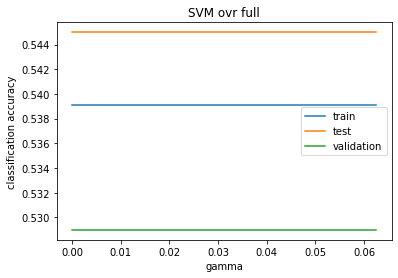

In [184]:
#plot the mean validation accuracy, train and test accuracy on the 3 data sets
gammas, train_accuracy, test_accuracy, validation_accuracy = plot_accuracy_svm_ovr(X_train, X_test, y_train, y_test, X, y)
plot_accuracy(gammas, {'train': train_accuracy, 
                          'test': test_accuracy,
                          'validation': validation_accuracy}, 'SVM ovr full')

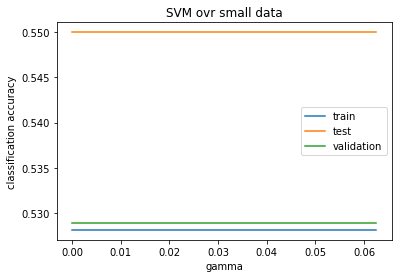

In [185]:
gammassmall, train_accuracysmall, test_accuracysmall, validation_accuracysmall = plot_accuracy_svm_ovr(Xsmall_train, Xsmall_test, ysmall_train, ysmall_test, X, y)
plot_accuracy(gammassmall, {'train': train_accuracysmall, 
                          'test': test_accuracysmall,
                          'validation': validation_accuracysmall}, 'SVM ovr small data')

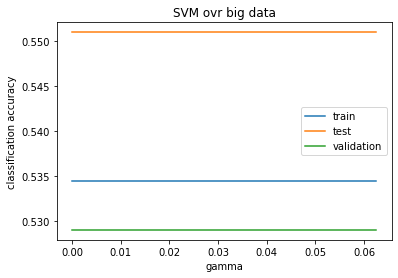

In [186]:
gammasbig, train_accuracybig, test_accuracybig, validation_accuracybig = plot_accuracy_svm_ovr(Xbig_train, Xbig_test, ybig_train, ybig_test, X, y)
plot_accuracy(gammasbig, {'train': train_accuracybig, 
                          'test': test_accuracybig,
                          'validation': validation_accuracybig}, 'SVM ovr big data')

In [187]:
#accuracies on the 3 data sets 
acc_validation_small = validation_accuracysmall[np.argmax(validation_accuracysmall)]
acc_validation = validation_accuracy[np.argmax(validation_accuracy)]
acc_validation_big = validation_accuracybig[np.argmax(validation_accuracybig)]

acc_train =  train_accuracy[np.argmax(train_accuracy)]
acc_trainsmall = train_accuracysmall[np.argmax(train_accuracysmall)]
acc_trainbig = train_accuracybig[np.argmax(train_accuracybig)]

acc_test  = test_accuracy[np.argmax(test_accuracy)]
acc_testsmall = test_accuracysmall[np.argmax(test_accuracysmall)]
acc_testbig = test_accuracybig[np.argmax(test_accuracybig)]

In [188]:
#add values to the accuracy table 
accuracy = accuracy.append({'model': 'SVM ovr full ','train_accuracy':acc_train,'test_accuracy':acc_test,'validation_accuracy': acc_validation}, ignore_index=True)
accuracy = accuracy.append({'model': 'SVM ovr small th','train_accuracy':acc_trainbig,'test_accuracy':acc_testbig,'validation_accuracy': acc_validation_big}, ignore_index=True)
accuracy = accuracy.append({'model': 'SVM ovr big th','train_accuracy':acc_trainsmall,'test_accuracy':acc_testsmall,'validation_accuracy': acc_validation_small}, ignore_index=True)

In [189]:
accuracy

,model,train_accuracy,test_accuracy,validation_accuracy
0,Logistic Regression full,0.541790,0.548961,0.534916
1,Logistic Regresion small th,0.526212,0.547972,0.528783
2,Logistic Regression big th,0.539565,0.550940,0.537685
3,NB full,0.515579,0.546983,0.518497
4,NB small th,0.513106,0.542038,0.516518
5,NB big th,0.513106,0.545994,0.517705
6,KNN full th,0.603858,0.462908,0.454797
7,KNN small th,0.595697,0.490603,0.469832
8,KNN big th,0.603116,0.508408,0.481306
9,SVM rbf full,0.538823,0.548961,0.532542


##LOGISTIC REGRESSION + KNN

In [190]:
#predict with both models

#logistic regression
Xsmall_train, Xsmall_test, ysmall_train, ysmall_test = train_test_split(Xsmall, y, test_size=0.2)

lr = LogisticRegression(solver='liblinear', multi_class='ovr',C=0.2)
lr.fit(Xsmall_train, ysmall_train)
y_lr_train= lr.predict(Xsmall_train)
y_lr_test = lr.predict(Xsmall_test)

#knn
knn = KNeighborsClassifier(n_neighbors=7)
#train model
knn.fit(Xsmall_train, ysmall_train)
y_pred_train_knn = knn.predict(Xsmall_train)
#Testing the model using X_test and storing the output in y_pred
y_pred_test_knn = knn.predict(Xsmall_test)

In [191]:
#train set
# get indexes of draws
ind= np.where(y_pred_train_knn == 1)
#replace those values with draws in logistic regression
for i in ind:
  y_lr_train[i]=1


#test set
# get indexes of draws
ind= np.where(y_pred_test_knn == 1)
#replace those values with draws in logistic regression
for i in ind:
  y_lr_test[i]=1

In [192]:
#get the accuracies
accuracy_trainsmall = accuracy_score(ysmall_train, y_lr_train)
accuracy_testsmall=accuracy_score(ysmall_test, y_lr_test)
print(accuracy_trainsmall,accuracy_testsmall)

0.5719584569732937 0.49455984174085066


In [193]:
#cross validation
#a function for cross validation for KNN
def cv_accuracy_knn(X, y):
    kf = KFold(n_splits=5)  # 5-fold cross validation
    #create empty arrays 
    accuracy_validation = np.empty((5))
    #for all folds splitting into training and validation set
    for k, (index_train, index_validation) in enumerate(kf.split(X)):  
        X_small_train, X_validation = X[index_train, :], X[index_validation, :]
        y_small_train, y_validation = y.iloc[index_train], y.iloc[index_validation]  
        # compute classification accuracy on validation set

         #train model knn
        lknn = KNeighborsClassifier(n_neighbors=7)
        knn.fit(X_small_train, y_small_train)
        predict_validation_knn = knn.predict(X_validation)  # validation 
        
        #train log reg
        llr = LogisticRegression(solver='liblinear', multi_class='ovr',C=0.2)
        llr.fit(X_small_train, y_small_train)
        predict_validation_llr = llr.predict(X_validation)  # validation 

        #change preds of log reg to draws
        #train set
        # get indexes of draws
        ind= np.where(predict_validation_knn == 1)
        #replace those values with draws in logistic regression
        for i in ind:
          predict_validation_llr[i]=1
        accuracy_validation[k] = accuracy_score(y_validation, predict_validation_llr)
    # compute mean validation accuracy for 5 folds
    # solution
    accuracy_validation = np.mean(accuracy_validation, axis=0)
    return accuracy_validation

In [194]:
accuracy_validationsmall = cv_accuracy_knn(Xsmall, y)
print(accuracy_validationsmall)

0.4987141444114738


In [195]:
#classification report
#classification report
target_names = ['H', 'D', 'A']
print(classification_report(ysmall_test,y_lr_test, target_names=target_names))

              precision    recall  f1-score   support

           H       0.56      0.70      0.62       493
           D       0.24      0.15      0.19       233
           A       0.47      0.42      0.44       285

    accuracy                           0.49      1011
   macro avg       0.43      0.42      0.42      1011
weighted avg       0.46      0.49      0.47      1011



In [196]:
accuracy = accuracy.append({'model': 'Logistic Regression + KNN big th','train_accuracy':accuracy_trainsmall,'test_accuracy':accuracy_testsmall,'validation_accuracy': accuracy_validationsmall}, ignore_index=True)

# 6. Results

## Table of accuracies

In [198]:
accuracy

,model,train_accuracy,test_accuracy,validation_accuracy
0,Logistic Regression full,0.541790,0.548961,0.534916
1,Logistic Regresion small th,0.526212,0.547972,0.528783
2,Logistic Regression big th,0.539565,0.550940,0.537685
3,NB full,0.515579,0.546983,0.518497
4,NB small th,0.513106,0.542038,0.516518
5,NB big th,0.513106,0.545994,0.517705
6,KNN full th,0.603858,0.462908,0.454797
7,KNN small th,0.595697,0.490603,0.469832
8,KNN big th,0.603116,0.508408,0.481306
9,SVM rbf full,0.538823,0.548961,0.532542


##Confusion matrices for 6 models

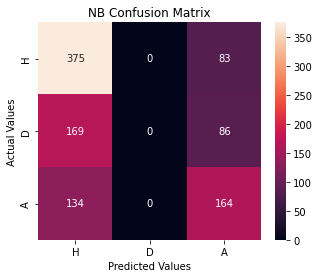

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
nb = MultinomialNB()
#train model
nb.fit(X_train, y_train)
nb.predict(X_train)
#Testing the model using X_test and storing the output in y_pred
y_pred = nb.predict(X_test)
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['H','D','A'], 
                     columns = ['H','D','A'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('NB Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [201]:
#classification report
target_names = ['H', 'D', 'A']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           H       0.55      0.82      0.66       458
           D       0.00      0.00      0.00       255
           A       0.49      0.55      0.52       298

    accuracy                           0.53      1011
   macro avg       0.35      0.46      0.39      1011
weighted avg       0.40      0.53      0.45      1011



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


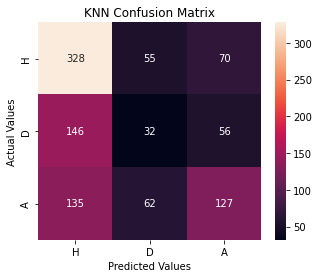

In [202]:
Xsmall_train, Xsmall_test, ysmall_train, ysmall_test = train_test_split(Xsmall, y, test_size=0.2)
knn = KNeighborsClassifier(n_neighbors=7)
#train model
knn.fit(Xsmall_train, ysmall_train)
knn.predict(Xsmall_train)
#Testing the model using X_test and storing the output in y_pred
y_pred = knn.predict(Xsmall_test)
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(ysmall_test, y_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['H','D','A'], 
                     columns = ['H','D','A'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('KNN Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


In [203]:
#classification report
target_names = ['H', 'D', 'A']
print(classification_report(ysmall_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           H       0.54      0.72      0.62       453
           D       0.21      0.14      0.17       234
           A       0.50      0.39      0.44       324

    accuracy                           0.48      1011
   macro avg       0.42      0.42      0.41      1011
weighted avg       0.45      0.48      0.46      1011



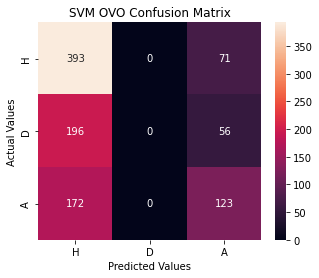

In [204]:
Xsmall_train, Xsmall_test, ysmall_train, ysmall_test = train_test_split(Xsmall, y, test_size=0.2)
svm = SVC(kernel='linear', decision_function_shape='ovo', gamma=2**-5)
svm.fit(Xsmall_train, ysmall_train)
svm.predict(Xsmall_train)
#Testing the model using X_test and storing the output in y_pred
y_pred = svm.predict(Xsmall_test)
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(ysmall_test, y_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['H','D','A'], 
                     columns = ['H','D','A'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('SVM OVO Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [205]:
#classification report
target_names = ['H', 'D', 'A']
print(classification_report(ysmall_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           H       0.52      0.85      0.64       464
           D       0.00      0.00      0.00       252
           A       0.49      0.42      0.45       295

    accuracy                           0.51      1011
   macro avg       0.34      0.42      0.36      1011
weighted avg       0.38      0.51      0.43      1011



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


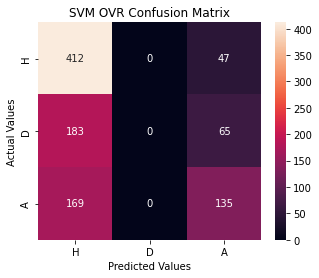

In [206]:
Xsmall_train, Xsmall_test, ysmall_train, ysmall_test = train_test_split(Xsmall, y, test_size=0.2)
svm = SVC(kernel='linear', decision_function_shape='ovr', gamma=2**-5)
svm.fit(Xsmall_train, ysmall_train)
svm.predict(Xsmall_train)
#Testing the model using X_test and storing the output in y_pred
y_pred = svm.predict(Xsmall_test)
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(ysmall_test, y_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['H','D','A'], 
                     columns = ['H','D','A'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('SVM OVR Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [207]:
#classification report
target_names = ['H', 'D', 'A']
print(classification_report(ysmall_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           H       0.54      0.90      0.67       459
           D       0.00      0.00      0.00       248
           A       0.55      0.44      0.49       304

    accuracy                           0.54      1011
   macro avg       0.36      0.45      0.39      1011
weighted avg       0.41      0.54      0.45      1011



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


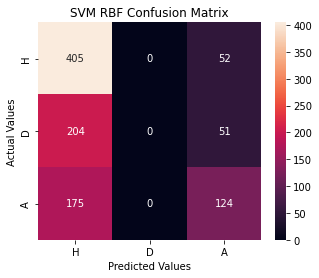

In [208]:
Xsmall_train, Xsmall_test, ysmall_train, ysmall_test = train_test_split(Xsmall, y, test_size=0.2)
svm = SVC(kernel='rbf', gamma=2**-5)
svm.fit(Xsmall_train, ysmall_train)
svm.predict(Xsmall_train)
#Testing the model using X_test and storing the output in y_pred
y_pred = svm.predict(Xsmall_test)
# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(ysmall_test, y_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = ['H','D','A'], 
                     columns = ['H','D','A'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('SVM RBF Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()


In [209]:
#classification report
target_names = ['H', 'D', 'A']
print(classification_report(ysmall_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           H       0.52      0.89      0.65       457
           D       0.00      0.00      0.00       255
           A       0.55      0.41      0.47       299

    accuracy                           0.52      1011
   macro avg       0.35      0.43      0.37      1011
weighted avg       0.40      0.52      0.43      1011



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


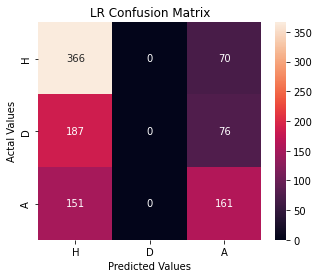

In [210]:
Xsmall_train, Xsmall_test, ysmall_train, ysmall_test = train_test_split(Xsmall, y, test_size=0.2)

lr = LogisticRegression(solver='liblinear', multi_class='ovr',C=0.2)
lr.fit(Xsmall_train, ysmall_train)
lr.predict(Xsmall_train)
y_lr_test = lr.predict(Xsmall_test)

lr_mat = confusion_matrix(ysmall_test, y_lr_test)
lr_mat_df = pd.DataFrame(lr_mat,
                     index = ['H','D','A'], 
                     columns = ['H','D','A'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(lr_mat_df, annot=True, fmt='g')
plt.title('LR Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [211]:
#classification report
target_names = ['H', 'D', 'A']
print(classification_report(ysmall_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           H       0.44      0.78      0.56       436
           D       0.00      0.00      0.00       263
           A       0.33      0.24      0.27       312

    accuracy                           0.41      1011
   macro avg       0.25      0.34      0.28      1011
weighted avg       0.29      0.41      0.33      1011



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [212]:
#how many draws are there in the train set (80% of train, in percentage)
len(y_train[y_train == 1])/len(y_train)

0.2443125618199802

In [213]:
#how many home wins are there in the train set (80% of train, in percentage)
len(y_train[y_train == 0])/len(y_train)

0.45450049455984176

In [214]:
#how many away wins are there in the train set (80% of train, in percentage)
len(y_train[y_train == 2])/len(y_train)

0.30118694362017806

## ROC, precision, and recall curves




In [226]:
# Binarize the output
binary_y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

In [227]:
Xsmall_train, Xsmall_test, ysmall_train, ysmall_test = train_test_split(Xsmall, binary_y, test_size=0.2)

In [228]:
classifier_lr = OneVsRestClassifier(
    LogisticRegression(solver='liblinear', C =0.2, multi_class='ovr')
)
y_score_lr = classifier_lr.fit(Xsmall_train, ysmall_train).decision_function(Xsmall_test)

In [229]:
def format_graph_text(i):
    if i == 0:
        return "H"
    elif i == 1:
        return "D"
    elif i == 2:
        return "A"

In [230]:
#Plotting ROC curve
def plot_roc(ysmall_test, y_score, curve_type):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ysmall_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(ysmall_test.ravel(), y_score.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.figure()
    lw = 2
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(format_graph_text(i), roc_auc[i]),
        )
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(curve_type + " ROC")
    plt.legend(loc="lower right")
    plt.show()

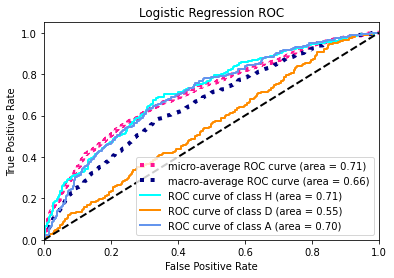

In [231]:
plot_roc(ysmall_test, y_score_lr, "Logistic Regression")

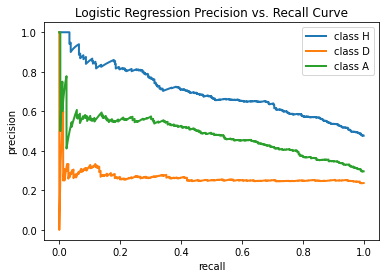

In [232]:
#plotting precision and recall
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(ysmall_test[:, i],
                                                        y_score_lr[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format( format_graph_text(i)))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("Logistic Regression Precision vs. Recall Curve")
plt.show()

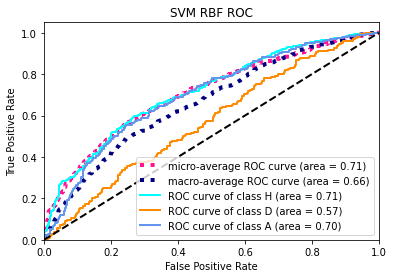

In [233]:
classifier_svm = OneVsRestClassifier(
    SVC(kernel='rbf', gamma=2**-5)
)
y_score_svm = classifier_svm.fit(Xsmall_train, ysmall_train).decision_function(Xsmall_test)
plot_roc(ysmall_test, y_score_svm, "SVM RBF")

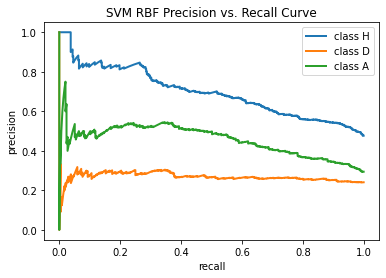

In [234]:
#plotting precision and recall
precision = dict()
recall = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(ysmall_test[:, i],
                                                        y_score_svm[:, i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(format_graph_text(i)))
plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("SVM RBF Precision vs. Recall Curve")
plt.show()

# 7. Final Predictions on Test Set


In [238]:
#a function for cross validation for logistic regression 
def cv_accuracy(X, y):
    kf = KFold(n_splits=5)  # 5-fold cross validation
    C=[0.001,0.005,0.01,0.05,0.1, 0.2]
    #create empty arrays 
    accuracy_validation = np.empty((5,len(C)))
    #for all folds splitting into training and validation set
    for k, (index_train, index_validation) in enumerate(kf.split(X)):  
        X_small_train, X_validation = X[index_train, :], X[index_validation, :]
        y_small_train, y_validation = y.iloc[index_train], y.iloc[index_validation]
        #loop for all hyperparameters
        for l, c in enumerate(C):
            # compute classification accuracy on validation set
            lr = LogisticRegression(solver='liblinear', C =c,multi_class='ovr')
            lr.fit(X_small_train, y_small_train)
            predict_validation = lr.predict(X_validation)  # validation 
            accuracy_validation[k,l] = accuracy_score(y_validation, predict_validation)
    # compute mean validation accuracy for 5 folds
    # solution
    accuracy_validation = np.mean(accuracy_validation, axis=0)
    return accuracy_validation

In [239]:
#Same steps as when first training logistic regression but on non-split data set
accuracies = cv_accuracy(Xsmall, y)
Cmax=C[np.argmax(accuracies)]
Cmax

0.2

In [240]:
lr = LogisticRegression(solver='liblinear', C =Cmax, multi_class='ovr')

In [241]:
lr.fit(Xsmall, y)

LogisticRegression(C=0.2, multi_class='ovr', solver='liblinear')

In [242]:
test = pd.read_csv("test_final.csv")
Xsmall_test_data = test[columns]
Xsmall_test_data

,away_avg_wins,home_avg_shots_on_target,team_away_avg_wins,home_avg_goal_diff_home,away_avg_goals,team_home_avg_wins,away_avg_goal_diff_away,home_avg_shots,team_away_avg_goal_diff_half,team_home_avg_goal_diff_half,home_avg_goals,home_avg_wins,team_home_avg_goal_diff_home,team_away_avg_goal_diff_away,Average Player Market Value Home,home_avg_goal_diff,Team Total Market Value Home,away_avg_goal_diff,home_avg_value,Average Player Market Value Away,Team Total Market Value Away,away_avg_value,team_home_avg_goal_diff,team_away_avg_goal_diff
0,0.566667,3.600000,0.785714,0.375000,1.666667,0.214286,0.000000,11.333333,0.619048,-0.619048,1.400000,0.433333,-1.100000,1.100000,14870000.0,-0.200000,371790000.0,0.066667,1.648061e+07,28280000.0,820130000.0,3.700606e+07,-1.238095,1.238095
1,0.433333,5.066667,0.000000,0.500000,1.000000,1.000000,-0.714286,12.933333,-0.333333,0.333333,1.866667,0.633333,2.000000,-2.000000,13280000.0,0.600000,318830000.0,-0.466667,1.959394e+07,9310000.0,232830000.0,1.531515e+07,1.333333,-1.333333
2,0.433333,2.933333,0.590909,-0.857143,1.266667,0.409091,-0.857143,10.666667,0.545455,-0.545455,0.533333,0.266667,0.000000,0.000000,5990000.0,-1.533333,167810000.0,-0.400000,7.809090e+06,14840000.0,385880000.0,1.806788e+07,-0.454545,0.454545
3,0.433333,3.933333,0.555556,-0.285714,1.266667,0.444444,-0.750000,11.933333,0.000000,0.000000,0.933333,0.533333,0.000000,0.000000,8900000.0,-0.133333,231300000.0,-0.133333,1.178061e+07,8630000.0,224510000.0,9.784848e+06,0.000000,0.000000
4,0.433333,3.333333,0.285714,-0.250000,0.933333,0.714286,-1.142857,10.933333,0.571429,-0.571429,0.800000,0.500000,0.666667,-0.666667,14400000.0,-0.066667,345690000.0,-0.466667,3.484848e+06,8830000.0,229680000.0,1.034545e+07,0.428571,-0.428571
5,0.433333,6.933333,0.500000,1.857143,1.266667,0.500000,-0.125000,19.133333,0.000000,0.000000,2.933333,0.800000,0.000000,0.000000,28880000.0,2.133333,779850000.0,-0.133333,3.612424e+07,5810000.0,179960000.0,9.163636e+06,0.000000,0.000000
6,0.533333,4.071429,0.500000,0.375000,1.200000,0.500000,-1.250000,10.857143,0.333333,-0.333333,1.142857,0.607143,0.692308,-0.692308,26140000.0,-0.071429,627300000.0,-0.266667,2.281818e+07,19510000.0,507150000.0,1.819697e+07,-0.259259,0.259259
7,0.766667,6.533333,0.462963,2.000000,2.333333,0.537037,1.500000,18.400000,-0.222222,0.222222,2.133333,0.800000,0.769231,-0.769231,40420000.0,1.533333,970020000.0,1.733333,4.460303e+07,29720000.0,802350000.0,2.814848e+07,0.370370,-0.370370
8,0.300000,3.400000,0.722222,-0.625000,1.333333,0.277778,-0.285714,11.866667,0.333333,-0.333333,1.133333,0.300000,-0.750000,0.750000,8830000.0,-0.866667,220860000.0,-0.600000,6.700000e+06,4850000.0,130950000.0,5.592121e+06,-0.666667,0.666667
9,0.466667,3.642857,0.615385,0.000000,1.533333,0.384615,-0.375000,11.000000,0.076923,-0.076923,1.000000,0.321429,0.166667,-0.166667,5450000.0,-0.500000,130770000.0,-0.266667,9.354545e+06,17620000.0,493290000.0,2.055758e+07,-0.461538,0.461538


In [243]:
Xsmall_test_data = scaler.transform(Xsmall_test_data)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [244]:
#predicting for the football games in 2022 and appending the predictions to create our prediction table
pred=lr.predict(Xsmall_test_data)
col = []
for i in pred:
    if i == 0:
      col.append('H')
    if i == 1:
      col.append('D')
    if i == 2:
      col.append('A')
final = pd.read_csv('epl-test.csv')
final['FTR'] = col
final.to_csv('Final_final_final_fival.csv')

In [245]:
final

,Date,HomeTeam,AwayTeam,FTR
0,15 Jan 22,Aston Villa,Man United,A
1,15 Jan 22,West Ham,Leeds,H
2,15 Jan 22,Norwich,Everton,A
3,15 Jan 22,Brighton,Crystal Palace,H
4,15 Jan 22,Wolves,Southampton,H
5,15 Jan 22,Liverpool,Brentford,H
6,15 Jan 22,Tottenham,Arsenal,H
7,15 Jan 22,Man City,Chelsea,H
8,15 Jan 22,Newcastle,Watford,H
9,15 Jan 22,Burnley,Leicester,A
